In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from collections import Counter
import math
import re
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

In [2]:
real_train=pd.read_csv('train.csv')
real_test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

In [3]:
real_train.head(1)
sample

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.1779,1.8892
1,2,0.1779,1.8892
2,3,0.1779,1.8892
3,4,0.1779,1.8892
4,5,0.1779,1.8892
5,6,0.1779,1.8892
6,7,0.1779,1.8892
7,8,0.1779,1.8892
8,9,0.1779,1.8892
9,10,0.1779,1.8892


# Data exploration

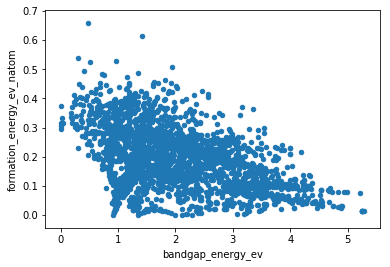

In [4]:
real_train.plot.scatter(x='bandgap_energy_ev',y='formation_energy_ev_natom')

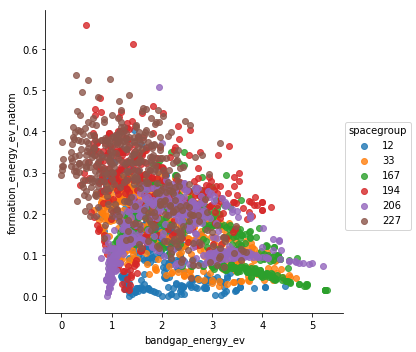

In [5]:
sns.lmplot('bandgap_energy_ev', 'formation_energy_ev_natom', data=real_train, hue='spacegroup', fit_reg=False)

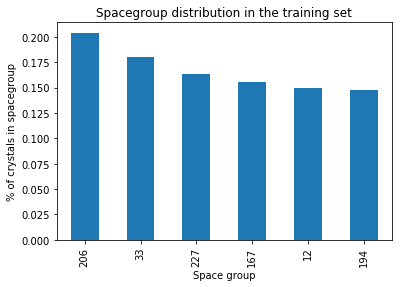

In [6]:
real_train['spacegroup'].value_counts(normalize=True).plot.bar()
plt.title('Spacegroup distribution in the training set')
plt.ylabel('% of crystals in spacegroup')
plt.xlabel('Space group')
plt.show()

In [7]:
def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    real_train['_'.join([lang, 'r'])] = np.pi * real_train[lang] / 180
    
# compute the cell volumes 
real_train['vol'] = get_vol(real_train['lattice_vector_1_ang'], 
                            real_train['lattice_vector_2_ang'], 
                            real_train['lattice_vector_3_ang'],
                            real_train['lattice_angle_alpha_degree_r'],
                            real_train['lattice_angle_beta_degree_r'], 
                            real_train['lattice_angle_gamma_degree_r'])

In [8]:
# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    real_test['_'.join([lang, 'r'])] = np.pi * real_test[lang] / 180
    
# compute the cell volumes 
real_test['vol'] = get_vol(real_test['lattice_vector_1_ang'], 
                            real_test['lattice_vector_2_ang'], 
                            real_test['lattice_vector_3_ang'],
                            real_test['lattice_angle_alpha_degree_r'],
                            real_test['lattice_angle_beta_degree_r'], 
                            real_test['lattice_angle_gamma_degree_r'])

In [9]:
# добавим количество каждого атома
for i in ['ga','in','al']:
    real_train[i+'_tcnt']=real_train.apply(lambda x: x['percent_atom_'+i]*x.number_of_total_atoms*2/5, axis=1)
    real_test[i+'_tcnt']=real_test.apply(lambda x: x['percent_atom_'+i]*x.number_of_total_atoms*2/5, axis=1)

real_train['o_tcnt']=real_train.apply(lambda x: x.number_of_total_atoms*3/5, axis=1)
real_test['o_tcnt']=real_test.apply(lambda x: x.number_of_total_atoms*3/5, axis=1)

In [10]:
# calculate the atomic density
# this is known to correlate with stability or bonding strength
real_train['atomic_density'] = real_train['number_of_total_atoms'] / real_train['vol']   
real_test['atomic_density'] = real_test['number_of_total_atoms'] / real_test['vol']

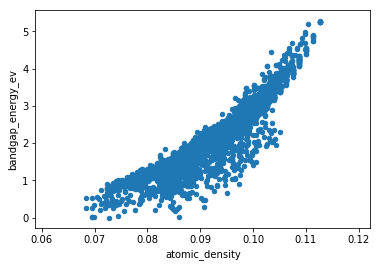

In [11]:
#bandgap_energy_ev atomic_density
real_train.plot.scatter(x='atomic_density',y='bandgap_energy_ev')

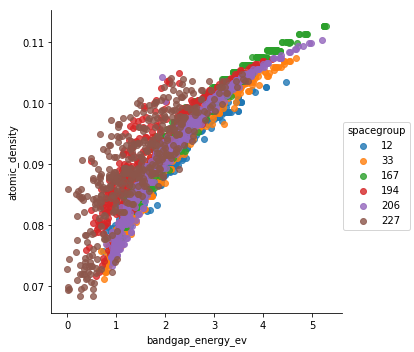

In [12]:
sns.lmplot('bandgap_energy_ev', 'atomic_density', data=real_train, hue='spacegroup', fit_reg=False)

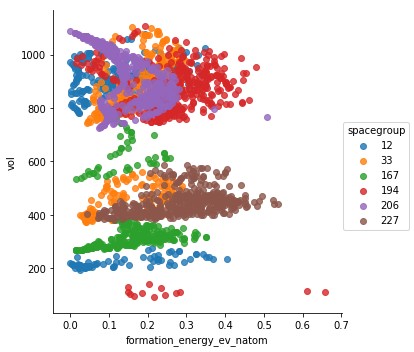

In [13]:
sns.lmplot('formation_energy_ev_natom', 'vol', data=real_train, hue='spacegroup', fit_reg=False)

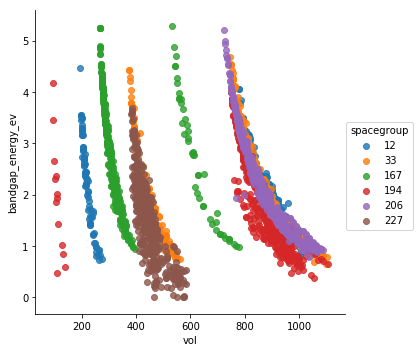

In [14]:
sns.lmplot('vol','bandgap_energy_ev', data=real_train, hue='spacegroup', fit_reg=False)

In [15]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=np.float),x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=np.float))
    return pos_data, np.array(lat_data)

In [16]:
ga_cols = []
al_cols = []
o_cols = []
in_cols = []

import warnings
warnings.filterwarnings("ignore")

for i in range(7):
    ga_cols.append("Ga_"+str(i))

for i in range(7):
    al_cols.append("Al_"+str(i))

for i in range(7):
    o_cols.append("O_"+str(i))

for i in range(7):
    in_cols.append("In_"+str(i))

ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

In [21]:
import os
cwd = os.getcwd()
for i in real_train.id.values:
    fn = cwd+"/train/{}/geometry.xyz".format(i)
    real_train_xyz, real_train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    ga_cnt = 0
    al_cnt = 0
    o_cnt = 0
    in_cnt = 0
    
    for li in real_train_xyz:
        if li[1] == "Ga":
            ga_cnt+=1
            ga_list.append(li[0])
        elif li[1] == "Al":
            al_list.append(li[0])
            al_cnt+=1
        elif li[1] == "In":
            in_list.append(li[0])
            in_cnt+=1
        elif li[1] == "O":
            o_cnt+=1
            o_list.append(li[0])
        
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga['Ga_6']=ga_cnt
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])
   

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al['Al_6']=al_cnt
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o['O_6']=o_cnt
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in['In_6']=in_cnt
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])

In [22]:
ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

real_train = pd.merge(real_train,ga_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,al_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,o_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,in_df,on = ["id"],how = "left")
    
ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)    

In [23]:
for i in real_test.id.values:
    fn = cwd+"/test/{}/geometry.xyz".format(i)
    real_train_xyz, real_train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    ga_cnt = 0
    al_cnt = 0
    o_cnt = 0
    in_cnt = 0
    
    for li in real_train_xyz:
        if li[1] == "Ga":
            ga_cnt+=1
            ga_list.append(li[0])
        elif li[1] == "Al":
            al_list.append(li[0])
            al_cnt+=1
        elif li[1] == "In":
            in_list.append(li[0])
            in_cnt+=1
        elif li[1] == "O":
            o_cnt+=1
            o_list.append(li[0])
    
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga['Ga_6']=ga_cnt
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])
   

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al['Al_6']=al_cnt
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o['O_6']=o_cnt
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in['In_6']=in_cnt
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    

ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

real_test = pd.merge(real_test,ga_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,al_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,o_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,in_df,on = ["id"],how = "left")

In [20]:
real_test.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,O_4,O_5,O_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,...,-7.607262,13.963306,48,-6.939157,-3.962924,-0.814587,6.795588,7.753744,-2.832664,11
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,...,-7.675262,12.922098,48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,...,18.630740,-0.982884,18,-4.914356,-1.223963,-3.590513,1.357926,8.504869,-0.133963,2
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,...,-25.392938,8.052706,48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,...,-25.471754,8.523775,48,27.301489,-0.108903,-12.967463,3.317993,-14.334026,-3.209089,10


In [21]:
len(real_test.columns)

49

In [22]:
len(real_train.columns)

51

In [23]:
def rmsle(h, y): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [24]:
X = real_train.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train['bandgap_energy_ev']+1)

In [25]:
test_id=real_test.id
real_test = real_test.drop(['id'], axis = 1)

In [52]:
params = {'depth':[3,4,5],
          'iterations':[100, 200,250,500],
          'learning_rate':[0.01, 0.03, 0.1, 0.2, 0.3], 
          'l2_leaf_reg':[0.1,1,3,5,10],
#           'boosting_type': 0,
          'ctr_description': 'Buckets',
#           'CtrBorderCount': 6,
#           'use_best_model': True,
#           'eval_metric': 'RMSE',
#           'ctr_description': ('Borders', , 'BinarizedTargetMeanValue', 'Counter'),
          'rsm': 0.8,
          'random_seed':42,
          'border_count':6,
#           'ctr_border_count':[50,100,200],
          'thread_count':4,
          'loss_function':'RMSE'}

In [53]:
# this function does 3-fold crossvalidation with catboostclassifier          
from sklearn.model_selection import KFold
def crossvaltest(param, train_set, features, target, cat_param,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        train_target=train[target]
        test_target=test[target]
        
        train=train[features]
        test=test[features]
        
        indices = np.where(np.in1d(train.columns, cat_param))[0]
        train_pool = Pool(train, train_target, cat_features=indices)
        test_pool = Pool(test,cat_features=indices)
        
        clf = CatBoostRegressor(**param)
        clf.fit(train_pool)
        preds=clf.predict(test_pool)
        res.append(np.sqrt(mean_squared_error(preds, test_target)))
    return np.mean(res)

In [54]:
# this function runs grid search on several parameters
from paramsearch import paramsearch
from itertools import product,chain
def catboost_param_tune(params,train_set, features, target, cat_param,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['learning_rate']),
                      ps.grid_search(['iterations']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms, train_set, features, target, cat_param,n_splits=3)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(-res,prms)
        print(res, prms, 'best:',-ps.bestscore(),ps.bestparam(),'\n')
    return ps.bestparam()

In [55]:
real_train['log_form']=Y_feen
feats=real_train.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [56]:
cat_param=['spacegroup']

In [57]:
bestparams = catboost_param_tune(params=params, train_set=real_train, features=feats, target='log_form',cat_param=cat_param)

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1888301	total: 75.7ms	remaining: 7.5s
1:	learn: 0.1871851	total: 77.4ms	remaining: 3.79s
2:	learn: 0.1855848	total: 79.2ms	remaining: 2.56s
3:	learn: 0.1839640	total: 80.8ms	remaining: 1.94s
4:	learn: 0.1824084	total: 81.8ms	remaining: 1.55s
5:	learn: 0.1808380	total: 83.2ms	remaining: 1.3s
6:	learn: 0.1792878	total: 84.8ms	remaining: 1.13s
7:	learn: 0.1777743	total: 86.3ms	remaining: 993ms
8:	learn: 0.1762739	total: 87.8ms	remaining: 888ms
9:	learn: 0.1747629	total: 89.3ms	remaining: 803ms
10:	learn: 0.1733023	total: 90.8ms	remaining: 735ms
11:	learn: 0.1718314	total: 92.1ms	remaining: 675ms
12:	learn: 0.1703061	total: 93.5ms	remaining: 626ms
13:	learn: 0.1688177	total: 94.9ms	remaining: 583ms
14:	learn: 0.1673303	total: 96.2ms	remaining: 545ms
15:	learn: 0.1659861	total: 97.2ms	remaining: 510ms
16:	learn: 0.1645449	total: 98.3ms	remaining: 480ms
17:	learn: 0.1631839	to

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1867014	total: 1.3ms	remaining: 129ms
1:	learn: 0.1850932	total: 2.73ms	remaining: 134ms
2:	learn: 0.1835113	total: 3.97ms	remaining: 128ms
3:	learn: 0.1819102	total: 5.4ms	remaining: 130ms
4:	learn: 0.1803749	total: 6.73ms	remaining: 128ms
5:	learn: 0.1788417	total: 8.15ms	remaining: 128ms
6:	learn: 0.1773067	total: 9.53ms	remaining: 127ms
7:	learn: 0.1758407	total: 10.4ms	remaining: 120ms
8:	learn: 0.1743664	total: 11.7ms	remaining: 118ms
9:	learn: 0.1728872	total: 13.1ms	remaining: 118ms
10:	learn: 0.1714959	total: 14.6ms	remaining: 118ms
11:	learn: 0.1700343	total: 16ms	remaining: 118ms
12:	learn: 0.1685922	total: 17.4ms	remaining: 117ms
13:	learn: 0.1672054	total: 18.9ms	remaining: 116ms
14:	learn: 0.1658322	total: 20.5ms	remaining: 116ms
15:	learn: 0.1644679	total: 22.1ms	remaining: 116ms
16:	learn: 0.1631049	total: 23.5ms	remaining: 115ms
17:	learn: 0.1617684	tota

86:	learn: 0.0964831	total: 109ms	remaining: 16.3ms
87:	learn: 0.0958556	total: 111ms	remaining: 15.2ms
88:	learn: 0.0951952	total: 116ms	remaining: 14.3ms
89:	learn: 0.0945782	total: 117ms	remaining: 13.1ms
90:	learn: 0.0940119	total: 119ms	remaining: 11.8ms
91:	learn: 0.0933667	total: 120ms	remaining: 10.5ms
92:	learn: 0.0927237	total: 122ms	remaining: 9.17ms
93:	learn: 0.0921405	total: 123ms	remaining: 7.86ms
94:	learn: 0.0915446	total: 124ms	remaining: 6.55ms
95:	learn: 0.0909922	total: 125ms	remaining: 5.23ms
96:	learn: 0.0904658	total: 127ms	remaining: 3.92ms
97:	learn: 0.0899000	total: 128ms	remaining: 2.61ms
98:	learn: 0.0892767	total: 129ms	remaining: 1.3ms
99:	learn: 0.0886888	total: 131ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1851467	total: 1.43ms	remaining: 142ms
1:	learn: 0.1836222	total: 2.85ms	remaining: 140ms
2:	learn: 0.1820742	total: 4.21ms	remaining: 136ms
3:	learn: 0.180507

0.0886449810026 {'depth': 3, 'iterations': 100, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0879430267791 {'depth': 3, 'iterations': 100, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1865354	total: 1.33ms	remaining: 132ms
1:	learn: 0.1849436	total: 2.94ms	remaining: 144ms
2:	learn: 0.1833932	total: 4.3ms	remaining: 139ms
3:	learn: 0.1818150	total: 5.62ms	remaining: 135ms
4:	learn: 0.1803117	total: 6.68ms	remaining: 127ms
5:	learn: 0.1788406	total: 7.75ms	remaining: 121ms
6:	learn: 0.1773262	total: 8.91ms	remaining: 118ms
7:	learn: 0.1758751	total: 9.85ms	remaining: 113ms
8:	learn: 0.1744133	total: 10.9ms	remaining: 110ms
9:	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1876257	total: 1.31ms	remaining: 129ms
1:	learn: 0.1860367	total: 2.81ms	remaining: 137ms
2:	learn: 0.1844792	total: 4.26ms	remaining: 138ms
3:	learn: 0.1829369	total: 5.68ms	remaining: 136ms
4:	learn: 0.1814309	total: 6.95ms	remaining: 132ms
5:	learn: 0.1799134	total: 8.19ms	remaining: 128ms
6:	learn: 0.1784142	total: 9.65ms	remaining: 128ms
7:	learn: 0.1769304	total: 11.2ms	remaining: 129ms
8:	learn: 0.1754681	total: 12.6ms	remaining: 128ms
9:	learn: 0.1739994	total: 14.2ms	remaining: 128ms
10:	learn: 0.1725754	total: 15.8ms	remaining: 128ms
11:	learn: 0.1711490	total: 17.1ms	remaining: 126ms
12:	learn: 0.1696629	total: 18.7ms	remaining: 125ms
13:	learn: 0.1682122	total: 19.9ms	remaining: 122ms
14:	learn: 0.1667616	total: 21.3ms	remaining: 121ms
15:	learn: 0.1654509	total: 22.9ms	remaining: 120ms
16:	learn: 0.1640416	total: 24.7ms	remaining: 120ms
17:	learn: 0.1627082	

66:	learn: 0.1133448	total: 105ms	remaining: 51.5ms
67:	learn: 0.1125430	total: 107ms	remaining: 50.1ms
68:	learn: 0.1117412	total: 108ms	remaining: 48.5ms
69:	learn: 0.1110119	total: 110ms	remaining: 47ms
70:	learn: 0.1102379	total: 111ms	remaining: 45.3ms
71:	learn: 0.1095016	total: 112ms	remaining: 43.6ms
72:	learn: 0.1087281	total: 113ms	remaining: 42ms
73:	learn: 0.1080391	total: 115ms	remaining: 40.3ms
74:	learn: 0.1073360	total: 116ms	remaining: 38.8ms
75:	learn: 0.1066483	total: 118ms	remaining: 37.2ms
76:	learn: 0.1059920	total: 119ms	remaining: 35.6ms
77:	learn: 0.1053129	total: 121ms	remaining: 34.1ms
78:	learn: 0.1046200	total: 123ms	remaining: 32.6ms
79:	learn: 0.1038884	total: 124ms	remaining: 31ms
80:	learn: 0.1032209	total: 126ms	remaining: 29.4ms
81:	learn: 0.1025234	total: 127ms	remaining: 27.9ms
82:	learn: 0.1018714	total: 128ms	remaining: 26.3ms
83:	learn: 0.1012023	total: 130ms	remaining: 24.8ms
84:	learn: 0.1005750	total: 132ms	remaining: 23.2ms
85:	learn: 0.09994

76:	learn: 0.1056722	total: 132ms	remaining: 39.4ms
77:	learn: 0.1049059	total: 133ms	remaining: 37.6ms
78:	learn: 0.1042435	total: 134ms	remaining: 35.7ms
79:	learn: 0.1035286	total: 135ms	remaining: 33.9ms
80:	learn: 0.1028220	total: 137ms	remaining: 32.1ms
81:	learn: 0.1021446	total: 138ms	remaining: 30.2ms
82:	learn: 0.1014918	total: 139ms	remaining: 28.5ms
83:	learn: 0.1008145	total: 140ms	remaining: 26.7ms
84:	learn: 0.1001125	total: 141ms	remaining: 24.9ms
85:	learn: 0.0994852	total: 142ms	remaining: 23.2ms
86:	learn: 0.0988067	total: 144ms	remaining: 21.5ms
87:	learn: 0.0981615	total: 145ms	remaining: 19.7ms
88:	learn: 0.0975074	total: 146ms	remaining: 18ms
89:	learn: 0.0969217	total: 147ms	remaining: 16.3ms
90:	learn: 0.0962411	total: 148ms	remaining: 14.6ms
91:	learn: 0.0955751	total: 149ms	remaining: 13ms
92:	learn: 0.0949447	total: 150ms	remaining: 11.3ms
93:	learn: 0.0943359	total: 151ms	remaining: 9.67ms
94:	learn: 0.0937079	total: 153ms	remaining: 8.03ms
95:	learn: 0.093

91:	learn: 0.0463654	total: 124ms	remaining: 10.7ms
92:	learn: 0.0460849	total: 125ms	remaining: 9.4ms
93:	learn: 0.0459273	total: 126ms	remaining: 8.05ms
94:	learn: 0.0457145	total: 127ms	remaining: 6.71ms
95:	learn: 0.0455126	total: 129ms	remaining: 5.36ms
96:	learn: 0.0453126	total: 130ms	remaining: 4.02ms
97:	learn: 0.0450688	total: 131ms	remaining: 2.68ms
98:	learn: 0.0449099	total: 133ms	remaining: 1.34ms
99:	learn: 0.0447871	total: 134ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1827148	total: 1.81ms	remaining: 179ms
1:	learn: 0.1779533	total: 3.42ms	remaining: 167ms
2:	learn: 0.1734046	total: 4.88ms	remaining: 158ms
3:	learn: 0.1689304	total: 6.47ms	remaining: 155ms
4:	learn: 0.1646927	total: 7.65ms	remaining: 145ms
5:	learn: 0.1603949	total: 9.34ms	remaining: 146ms
6:	learn: 0.1563932	total: 11.1ms	remaining: 147ms
7:	learn: 0.1525934	total: 12.6ms	remaining: 145ms
8:	learn: 0.1488887	tot

64:	learn: 0.0358127	total: 108ms	remaining: 58.2ms
65:	learn: 0.0357653	total: 111ms	remaining: 57ms
66:	learn: 0.0356552	total: 112ms	remaining: 55.2ms
67:	learn: 0.0355191	total: 114ms	remaining: 53.5ms
68:	learn: 0.0353958	total: 115ms	remaining: 51.7ms
69:	learn: 0.0353608	total: 116ms	remaining: 49.9ms
70:	learn: 0.0353041	total: 118ms	remaining: 48.2ms
71:	learn: 0.0352561	total: 120ms	remaining: 46.5ms
72:	learn: 0.0351540	total: 121ms	remaining: 44.9ms
73:	learn: 0.0350536	total: 123ms	remaining: 43.3ms
74:	learn: 0.0349659	total: 125ms	remaining: 41.6ms
75:	learn: 0.0348173	total: 127ms	remaining: 40.1ms
76:	learn: 0.0347322	total: 128ms	remaining: 38.4ms
77:	learn: 0.0345609	total: 130ms	remaining: 36.6ms
78:	learn: 0.0344782	total: 131ms	remaining: 34.8ms
79:	learn: 0.0344108	total: 132ms	remaining: 33ms
80:	learn: 0.0343303	total: 133ms	remaining: 31.2ms
81:	learn: 0.0342601	total: 134ms	remaining: 29.4ms
82:	learn: 0.0341857	total: 135ms	remaining: 27.7ms
83:	learn: 0.034

0.0348646096955 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0348646095559 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1564618	total: 1.47ms	remaining: 146ms
1:	learn: 0.1313949	total: 2.71ms	remaining: 133ms
2:	learn: 0.1109582	total: 3.99ms	remaining: 129ms
3:	learn: 0.0949791	total: 5.28ms	remaining: 127ms
4:	learn: 0.0833081	total: 6.36ms	remaining: 121ms
5:	learn: 0.0733162	total: 7.41ms	remaining: 116ms
6:	learn: 0.0648782	total: 8.42ms	remaining: 112ms
7:	learn: 0.0597786	total: 9.38ms	remaining: 108ms
8:	learn: 0.0552183	total: 10.5ms	remaining: 106ms
9:	l

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1552494	total: 1.39ms	remaining: 138ms
1:	learn: 0.1303805	total: 3.16ms	remaining: 155ms
2:	learn: 0.1114327	total: 4.58ms	remaining: 148ms
3:	learn: 0.0949958	total: 5.69ms	remaining: 137ms
4:	learn: 0.0826773	total: 6.87ms	remaining: 130ms
5:	learn: 0.0730330	total: 8.2ms	remaining: 128ms
6:	learn: 0.0654025	total: 9.36ms	remaining: 124ms
7:	learn: 0.0608034	total: 10.7ms	remaining: 122ms
8:	learn: 0.0564259	total: 11.9ms	remaining: 120ms
9:	learn: 0.0532856	total: 13.1ms	remaining: 118ms
10:	learn: 0.0510868	total: 14.2ms	remaining: 115ms
11:	learn: 0.0494752	total: 15.4ms	remaining: 113ms
12:	learn: 0.0472911	total: 16.7ms	remaining: 112ms
13:	learn: 0.0459319	total: 18ms	remaining: 110ms
14:	learn: 0.0446162	total: 19.2ms	remaining: 109ms
15:	learn: 0.0436384	total: 20.5ms	remaining: 108ms
16:	learn: 0.0430280	total: 21.8ms	remaining: 107ms
17:	learn: 0.0425116	tot

86:	learn: 0.0304453	total: 101ms	remaining: 15.1ms
87:	learn: 0.0303990	total: 103ms	remaining: 14ms
88:	learn: 0.0303949	total: 104ms	remaining: 12.8ms
89:	learn: 0.0303230	total: 105ms	remaining: 11.7ms
90:	learn: 0.0302619	total: 107ms	remaining: 10.6ms
91:	learn: 0.0302036	total: 109ms	remaining: 9.45ms
92:	learn: 0.0301563	total: 110ms	remaining: 8.3ms
93:	learn: 0.0301500	total: 112ms	remaining: 7.14ms
94:	learn: 0.0301455	total: 114ms	remaining: 5.98ms
95:	learn: 0.0301278	total: 115ms	remaining: 4.8ms
96:	learn: 0.0300809	total: 117ms	remaining: 3.61ms
97:	learn: 0.0300512	total: 118ms	remaining: 2.4ms
98:	learn: 0.0300110	total: 119ms	remaining: 1.2ms
99:	learn: 0.0299873	total: 120ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1390909	total: 1.31ms	remaining: 130ms
1:	learn: 0.1073746	total: 2.92ms	remaining: 143ms
2:	learn: 0.0855227	total: 4.24ms	remaining: 137ms
3:	learn: 0.0708267	tot

83:	learn: 0.0309953	total: 125ms	remaining: 23.9ms
84:	learn: 0.0309259	total: 127ms	remaining: 22.4ms
85:	learn: 0.0308935	total: 128ms	remaining: 20.9ms
86:	learn: 0.0308863	total: 129ms	remaining: 19.3ms
87:	learn: 0.0308125	total: 130ms	remaining: 17.7ms
88:	learn: 0.0307952	total: 131ms	remaining: 16.2ms
89:	learn: 0.0307356	total: 132ms	remaining: 14.7ms
90:	learn: 0.0306652	total: 133ms	remaining: 13.2ms
91:	learn: 0.0306482	total: 135ms	remaining: 11.7ms
92:	learn: 0.0306390	total: 136ms	remaining: 10.2ms
93:	learn: 0.0305791	total: 137ms	remaining: 8.73ms
94:	learn: 0.0305784	total: 138ms	remaining: 7.25ms
95:	learn: 0.0305333	total: 139ms	remaining: 5.78ms
96:	learn: 0.0304612	total: 140ms	remaining: 4.32ms
97:	learn: 0.0303915	total: 141ms	remaining: 2.88ms
98:	learn: 0.0303639	total: 142ms	remaining: 1.44ms
99:	learn: 0.0302901	total: 143ms	remaining: 0us
0.0338616523243 {'depth': 3, 'iterations': 100, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', '

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1408212	total: 1.24ms	remaining: 247ms
1:	learn: 0.1086389	total: 2.69ms	remaining: 267ms
2:	learn: 0.0868333	total: 4.08ms	remaining: 268ms
3:	learn: 0.0721697	total: 5.41ms	remaining: 265ms
4:	learn: 0.0632759	total: 6.51ms	remaining: 254ms
5:	learn: 0.0551750	total: 7.59ms	remaining: 245ms
6:	learn: 0.0504280	total: 8.89ms	remaining: 245ms
7:	learn: 0.0470454	total: 10.1ms	remaining: 243ms
8:	learn: 0.0449489	total: 11.3ms	remaining: 241ms
9:	learn: 0.0432786	total: 12.8ms	remaining: 242ms
10:	learn: 0.0423224	total: 14.1ms	remaining: 242ms
11:	learn: 0.0414437	total: 15.4ms	remaining: 242ms
12:	learn: 0.0408229	total: 16.8ms	remaining: 241ms
13:	learn: 0.0397487	total: 18ms	remaining: 239ms
14:	learn: 0.0387070	total: 19.3ms	remaining: 238ms
15:	learn: 0.0381694	total: 20.8ms	remaining: 239ms
16:	learn: 0.0380218	total: 22ms	remaining: 237ms
17:	learn: 0.0375729	tota

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1398734	total: 1.55ms	remaining: 308ms
1:	learn: 0.1077173	total: 3.35ms	remaining: 331ms
2:	learn: 0.0856052	total: 4.83ms	remaining: 317ms
3:	learn: 0.0708473	total: 6.26ms	remaining: 307ms
4:	learn: 0.0623111	total: 7.6ms	remaining: 297ms
5:	learn: 0.0570529	total: 8.95ms	remaining: 289ms
6:	learn: 0.0525907	total: 10.2ms	remaining: 281ms
7:	learn: 0.0489815	total: 11.4ms	remaining: 272ms
8:	learn: 0.0471100	total: 12.5ms	remaining: 266ms
9:	learn: 0.0454135	total: 13.7ms	remaining: 260ms
10:	learn: 0.0441560	total: 15ms	remaining: 258ms
11:	learn: 0.0428898	total: 16.1ms	remaining: 252ms
12:	learn: 0.0418216	total: 17.2ms	remaining: 248ms
13:	learn: 0.0413863	total: 18.5ms	remaining: 245ms
14:	learn: 0.0402374	total: 19.8ms	remaining: 244ms
15:	learn: 0.0397817	total: 20.9ms	remaining: 241ms
16:	learn: 0.0391733	total: 22.1ms	remaining: 238ms
17:	learn: 0.0388104	tot

0.0340607123584 {'depth': 3, 'iterations': 200, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0338616522114 {'depth': 3, 'iterations': 100, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1396948	total: 1.43ms	remaining: 356ms
1:	learn: 0.1081610	total: 3.21ms	remaining: 397ms
2:	learn: 0.0857189	total: 5.63ms	remaining: 464ms
3:	learn: 0.0704262	total: 7.47ms	remaining: 460ms
4:	learn: 0.0603460	total: 9.1ms	remaining: 446ms
5:	learn: 0.0543371	total: 10.8ms	remaining: 440ms
6:	learn: 0.0504975	total: 12.6ms	remaining: 437ms
7:	learn: 0.0463011	total: 14.1ms	remaining: 426ms
8:	learn: 0.0438948	total: 15.7ms	remaining: 420ms
9:	le

177:	learn: 0.0263322	total: 296ms	remaining: 120ms
178:	learn: 0.0263218	total: 298ms	remaining: 118ms
179:	learn: 0.0263105	total: 300ms	remaining: 117ms
180:	learn: 0.0263005	total: 302ms	remaining: 115ms
181:	learn: 0.0262623	total: 304ms	remaining: 113ms
182:	learn: 0.0262525	total: 306ms	remaining: 112ms
183:	learn: 0.0262370	total: 308ms	remaining: 110ms
184:	learn: 0.0262169	total: 309ms	remaining: 109ms
185:	learn: 0.0262105	total: 311ms	remaining: 107ms
186:	learn: 0.0261827	total: 313ms	remaining: 105ms
187:	learn: 0.0261664	total: 314ms	remaining: 104ms
188:	learn: 0.0261624	total: 316ms	remaining: 102ms
189:	learn: 0.0261531	total: 317ms	remaining: 100ms
190:	learn: 0.0261358	total: 319ms	remaining: 98.5ms
191:	learn: 0.0261123	total: 320ms	remaining: 96.8ms
192:	learn: 0.0261096	total: 322ms	remaining: 95.1ms
193:	learn: 0.0260444	total: 323ms	remaining: 93.3ms
194:	learn: 0.0260062	total: 325ms	remaining: 91.6ms
195:	learn: 0.0259975	total: 326ms	remaining: 89.9ms
196:	l

210:	learn: 0.0275260	total: 310ms	remaining: 57.2ms
211:	learn: 0.0275214	total: 311ms	remaining: 55.8ms
212:	learn: 0.0275074	total: 313ms	remaining: 54.4ms
213:	learn: 0.0274428	total: 314ms	remaining: 52.9ms
214:	learn: 0.0274264	total: 316ms	remaining: 51.4ms
215:	learn: 0.0274188	total: 317ms	remaining: 49.9ms
216:	learn: 0.0274183	total: 319ms	remaining: 48.4ms
217:	learn: 0.0273906	total: 320ms	remaining: 47ms
218:	learn: 0.0273628	total: 323ms	remaining: 45.7ms
219:	learn: 0.0273625	total: 325ms	remaining: 44.3ms
220:	learn: 0.0273435	total: 327ms	remaining: 42.9ms
221:	learn: 0.0273275	total: 329ms	remaining: 41.5ms
222:	learn: 0.0273027	total: 331ms	remaining: 40ms
223:	learn: 0.0272770	total: 332ms	remaining: 38.5ms
224:	learn: 0.0272601	total: 333ms	remaining: 37ms
225:	learn: 0.0272489	total: 334ms	remaining: 35.5ms
226:	learn: 0.0272389	total: 336ms	remaining: 34ms
227:	learn: 0.0272359	total: 337ms	remaining: 32.5ms
228:	learn: 0.0272324	total: 339ms	remaining: 31ms
229

239:	learn: 0.0279531	total: 315ms	remaining: 13.1ms
240:	learn: 0.0279411	total: 316ms	remaining: 11.8ms
241:	learn: 0.0279183	total: 318ms	remaining: 10.5ms
242:	learn: 0.0279020	total: 320ms	remaining: 9.22ms
243:	learn: 0.0278876	total: 321ms	remaining: 7.9ms
244:	learn: 0.0278865	total: 323ms	remaining: 6.59ms
245:	learn: 0.0278796	total: 325ms	remaining: 5.28ms
246:	learn: 0.0278778	total: 327ms	remaining: 3.97ms
247:	learn: 0.0278775	total: 328ms	remaining: 2.65ms
248:	learn: 0.0278741	total: 330ms	remaining: 1.32ms
249:	learn: 0.0278712	total: 331ms	remaining: 0us
0.0332749269599 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0332749267927 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function':

166:	learn: 0.0274310	total: 195ms	remaining: 388ms
167:	learn: 0.0274239	total: 196ms	remaining: 387ms
168:	learn: 0.0274234	total: 197ms	remaining: 386ms
169:	learn: 0.0274231	total: 198ms	remaining: 385ms
170:	learn: 0.0274039	total: 199ms	remaining: 384ms
171:	learn: 0.0274037	total: 201ms	remaining: 382ms
172:	learn: 0.0273902	total: 202ms	remaining: 381ms
173:	learn: 0.0273896	total: 203ms	remaining: 380ms
174:	learn: 0.0273433	total: 204ms	remaining: 379ms
175:	learn: 0.0273419	total: 205ms	remaining: 378ms
176:	learn: 0.0273407	total: 206ms	remaining: 377ms
177:	learn: 0.0273407	total: 207ms	remaining: 375ms
178:	learn: 0.0273052	total: 208ms	remaining: 374ms
179:	learn: 0.0272762	total: 209ms	remaining: 372ms
180:	learn: 0.0272377	total: 210ms	remaining: 371ms
181:	learn: 0.0272275	total: 212ms	remaining: 370ms
182:	learn: 0.0271578	total: 213ms	remaining: 369ms
183:	learn: 0.0271571	total: 214ms	remaining: 368ms
184:	learn: 0.0271219	total: 215ms	remaining: 367ms
185:	learn: 

487:	learn: 0.0234408	total: 578ms	remaining: 14.2ms
488:	learn: 0.0234392	total: 580ms	remaining: 13.1ms
489:	learn: 0.0234257	total: 582ms	remaining: 11.9ms
490:	learn: 0.0234231	total: 584ms	remaining: 10.7ms
491:	learn: 0.0234218	total: 586ms	remaining: 9.53ms
492:	learn: 0.0234138	total: 588ms	remaining: 8.34ms
493:	learn: 0.0234117	total: 589ms	remaining: 7.16ms
494:	learn: 0.0234021	total: 591ms	remaining: 5.97ms
495:	learn: 0.0233899	total: 593ms	remaining: 4.78ms
496:	learn: 0.0233777	total: 595ms	remaining: 3.59ms
497:	learn: 0.0233737	total: 597ms	remaining: 2.4ms
498:	learn: 0.0233269	total: 599ms	remaining: 1.2ms
499:	learn: 0.0233268	total: 601ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1401977	total: 1.32ms	remaining: 657ms
1:	learn: 0.1080672	total: 2.75ms	remaining: 684ms
2:	learn: 0.0854949	total: 4.14ms	remaining: 685ms
3:	learn: 0.0707569	total: 5.3ms	remaining: 657ms
4:	learn

145:	learn: 0.0289322	total: 193ms	remaining: 468ms
146:	learn: 0.0289161	total: 195ms	remaining: 469ms
147:	learn: 0.0288871	total: 197ms	remaining: 468ms
148:	learn: 0.0288781	total: 199ms	remaining: 469ms
149:	learn: 0.0288766	total: 201ms	remaining: 469ms
150:	learn: 0.0288386	total: 202ms	remaining: 467ms
151:	learn: 0.0288030	total: 203ms	remaining: 465ms
152:	learn: 0.0287971	total: 205ms	remaining: 464ms
153:	learn: 0.0287592	total: 206ms	remaining: 463ms
154:	learn: 0.0287299	total: 207ms	remaining: 462ms
155:	learn: 0.0287248	total: 209ms	remaining: 460ms
156:	learn: 0.0287071	total: 210ms	remaining: 459ms
157:	learn: 0.0286949	total: 211ms	remaining: 458ms
158:	learn: 0.0286664	total: 213ms	remaining: 456ms
159:	learn: 0.0286328	total: 214ms	remaining: 455ms
160:	learn: 0.0286224	total: 215ms	remaining: 453ms
161:	learn: 0.0286065	total: 217ms	remaining: 452ms
162:	learn: 0.0285816	total: 218ms	remaining: 450ms
163:	learn: 0.0285513	total: 219ms	remaining: 449ms
164:	learn: 

317:	learn: 0.0265482	total: 385ms	remaining: 220ms
318:	learn: 0.0265358	total: 389ms	remaining: 220ms
319:	learn: 0.0265344	total: 390ms	remaining: 219ms
320:	learn: 0.0265196	total: 391ms	remaining: 218ms
321:	learn: 0.0265190	total: 393ms	remaining: 217ms
322:	learn: 0.0265181	total: 394ms	remaining: 216ms
323:	learn: 0.0265137	total: 395ms	remaining: 215ms
324:	learn: 0.0265031	total: 397ms	remaining: 214ms
325:	learn: 0.0264712	total: 398ms	remaining: 213ms
326:	learn: 0.0264675	total: 400ms	remaining: 212ms
327:	learn: 0.0264647	total: 401ms	remaining: 210ms
328:	learn: 0.0264415	total: 403ms	remaining: 210ms
329:	learn: 0.0264281	total: 405ms	remaining: 209ms
330:	learn: 0.0264201	total: 407ms	remaining: 208ms
331:	learn: 0.0264138	total: 409ms	remaining: 207ms
332:	learn: 0.0264108	total: 411ms	remaining: 206ms
333:	learn: 0.0264103	total: 412ms	remaining: 205ms
334:	learn: 0.0264081	total: 414ms	remaining: 204ms
335:	learn: 0.0264015	total: 416ms	remaining: 203ms
336:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1411973	total: 1.72ms	remaining: 857ms
1:	learn: 0.1089434	total: 3.13ms	remaining: 780ms
2:	learn: 0.0864770	total: 4.64ms	remaining: 769ms
3:	learn: 0.0717750	total: 6.04ms	remaining: 749ms
4:	learn: 0.0615007	total: 7.25ms	remaining: 718ms
5:	learn: 0.0547188	total: 8.51ms	remaining: 701ms
6:	learn: 0.0508775	total: 9.87ms	remaining: 695ms
7:	learn: 0.0488184	total: 11.3ms	remaining: 693ms
8:	learn: 0.0472525	total: 12.6ms	remaining: 690ms
9:	learn: 0.0451176	total: 14.1ms	remaining: 689ms
10:	learn: 0.0436299	total: 15.4ms	remaining: 686ms
11:	learn: 0.0427704	total: 16.9ms	remaining: 687ms
12:	learn: 0.0419406	total: 18.1ms	remaining: 679ms
13:	learn: 0.0413094	total: 19.5ms	remaining: 678ms
14:	learn: 0.0408676	total: 20.9ms	remaining: 675ms
15:	learn: 0.0398124	total: 22.4ms	remaining: 676ms
16:	learn: 0.0393473	total: 24.1ms	remaining: 685ms
17:	learn: 0.0389381	

214:	learn: 0.0287303	total: 322ms	remaining: 427ms
215:	learn: 0.0287243	total: 324ms	remaining: 425ms
216:	learn: 0.0287203	total: 325ms	remaining: 424ms
217:	learn: 0.0287114	total: 327ms	remaining: 423ms
218:	learn: 0.0286909	total: 329ms	remaining: 422ms
219:	learn: 0.0286844	total: 331ms	remaining: 421ms
220:	learn: 0.0286746	total: 333ms	remaining: 420ms
221:	learn: 0.0286491	total: 335ms	remaining: 419ms
222:	learn: 0.0286118	total: 337ms	remaining: 418ms
223:	learn: 0.0285781	total: 339ms	remaining: 417ms
224:	learn: 0.0285322	total: 341ms	remaining: 416ms
225:	learn: 0.0284678	total: 342ms	remaining: 415ms
226:	learn: 0.0283278	total: 344ms	remaining: 413ms
227:	learn: 0.0283036	total: 346ms	remaining: 412ms
228:	learn: 0.0282907	total: 347ms	remaining: 410ms
229:	learn: 0.0282822	total: 348ms	remaining: 409ms
230:	learn: 0.0282781	total: 349ms	remaining: 407ms
231:	learn: 0.0282479	total: 351ms	remaining: 405ms
232:	learn: 0.0282475	total: 352ms	remaining: 404ms
233:	learn: 

478:	learn: 0.0254159	total: 708ms	remaining: 31ms
479:	learn: 0.0254105	total: 710ms	remaining: 29.6ms
480:	learn: 0.0254103	total: 712ms	remaining: 28.1ms
481:	learn: 0.0254014	total: 714ms	remaining: 26.7ms
482:	learn: 0.0253960	total: 715ms	remaining: 25.2ms
483:	learn: 0.0253953	total: 717ms	remaining: 23.7ms
484:	learn: 0.0253881	total: 719ms	remaining: 22.2ms
485:	learn: 0.0253833	total: 721ms	remaining: 20.8ms
486:	learn: 0.0253816	total: 722ms	remaining: 19.3ms
487:	learn: 0.0253615	total: 724ms	remaining: 17.8ms
488:	learn: 0.0253607	total: 726ms	remaining: 16.3ms
489:	learn: 0.0253554	total: 727ms	remaining: 14.8ms
490:	learn: 0.0253461	total: 729ms	remaining: 13.4ms
491:	learn: 0.0253375	total: 731ms	remaining: 11.9ms
492:	learn: 0.0253197	total: 732ms	remaining: 10.4ms
493:	learn: 0.0252977	total: 734ms	remaining: 8.91ms
494:	learn: 0.0252928	total: 735ms	remaining: 7.42ms
495:	learn: 0.0252875	total: 736ms	remaining: 5.94ms
496:	learn: 0.0252849	total: 737ms	remaining: 4.

205:	learn: 0.0237294	total: 388ms	remaining: 82.9ms
206:	learn: 0.0237035	total: 390ms	remaining: 81ms
207:	learn: 0.0236743	total: 392ms	remaining: 79.2ms
208:	learn: 0.0236648	total: 394ms	remaining: 77.3ms
209:	learn: 0.0236525	total: 400ms	remaining: 76.1ms
210:	learn: 0.0236426	total: 402ms	remaining: 74.2ms
211:	learn: 0.0236297	total: 403ms	remaining: 72.3ms
212:	learn: 0.0236191	total: 405ms	remaining: 70.4ms
213:	learn: 0.0236106	total: 407ms	remaining: 68.5ms
214:	learn: 0.0236046	total: 409ms	remaining: 66.5ms
215:	learn: 0.0235973	total: 411ms	remaining: 64.7ms
216:	learn: 0.0235376	total: 413ms	remaining: 62.8ms
217:	learn: 0.0235318	total: 415ms	remaining: 60.8ms
218:	learn: 0.0235136	total: 417ms	remaining: 59ms
219:	learn: 0.0234830	total: 418ms	remaining: 57ms
220:	learn: 0.0234788	total: 420ms	remaining: 55.1ms
221:	learn: 0.0234641	total: 422ms	remaining: 53.2ms
222:	learn: 0.0234397	total: 424ms	remaining: 51.4ms
223:	learn: 0.0234356	total: 427ms	remaining: 49.5ms

175:	learn: 0.0260376	total: 327ms	remaining: 137ms
176:	learn: 0.0260098	total: 329ms	remaining: 136ms
177:	learn: 0.0259803	total: 332ms	remaining: 134ms
178:	learn: 0.0259578	total: 334ms	remaining: 132ms
179:	learn: 0.0259536	total: 336ms	remaining: 131ms
180:	learn: 0.0259303	total: 338ms	remaining: 129ms
181:	learn: 0.0259303	total: 339ms	remaining: 127ms
182:	learn: 0.0259129	total: 340ms	remaining: 125ms
183:	learn: 0.0259011	total: 343ms	remaining: 123ms
184:	learn: 0.0257949	total: 345ms	remaining: 121ms
185:	learn: 0.0257733	total: 347ms	remaining: 119ms
186:	learn: 0.0256735	total: 349ms	remaining: 118ms
187:	learn: 0.0255952	total: 351ms	remaining: 116ms
188:	learn: 0.0255922	total: 353ms	remaining: 114ms
189:	learn: 0.0255231	total: 354ms	remaining: 112ms
190:	learn: 0.0255106	total: 356ms	remaining: 110ms
191:	learn: 0.0254949	total: 359ms	remaining: 108ms
192:	learn: 0.0254867	total: 361ms	remaining: 106ms
193:	learn: 0.0254717	total: 363ms	remaining: 105ms
194:	learn: 

184:	learn: 0.0245878	total: 324ms	remaining: 114ms
185:	learn: 0.0245821	total: 326ms	remaining: 112ms
186:	learn: 0.0245622	total: 329ms	remaining: 111ms
187:	learn: 0.0245042	total: 331ms	remaining: 109ms
188:	learn: 0.0245007	total: 332ms	remaining: 107ms
189:	learn: 0.0244525	total: 334ms	remaining: 106ms
190:	learn: 0.0244120	total: 337ms	remaining: 104ms
191:	learn: 0.0243892	total: 339ms	remaining: 102ms
192:	learn: 0.0243867	total: 341ms	remaining: 101ms
193:	learn: 0.0243820	total: 342ms	remaining: 98.8ms
194:	learn: 0.0243737	total: 344ms	remaining: 97.1ms
195:	learn: 0.0243439	total: 346ms	remaining: 95.4ms
196:	learn: 0.0242927	total: 348ms	remaining: 93.7ms
197:	learn: 0.0242902	total: 350ms	remaining: 92ms
198:	learn: 0.0242871	total: 352ms	remaining: 90.3ms
199:	learn: 0.0242581	total: 354ms	remaining: 88.6ms
200:	learn: 0.0242479	total: 356ms	remaining: 86.8ms
201:	learn: 0.0242359	total: 358ms	remaining: 85ms
202:	learn: 0.0242320	total: 360ms	remaining: 83.4ms
203:	l

134:	learn: 0.0244293	total: 300ms	remaining: 255ms
135:	learn: 0.0243750	total: 302ms	remaining: 253ms
136:	learn: 0.0242668	total: 305ms	remaining: 252ms
137:	learn: 0.0241593	total: 308ms	remaining: 250ms
138:	learn: 0.0241421	total: 310ms	remaining: 248ms
139:	learn: 0.0241378	total: 313ms	remaining: 246ms
140:	learn: 0.0241354	total: 316ms	remaining: 244ms
141:	learn: 0.0240967	total: 318ms	remaining: 241ms
142:	learn: 0.0239789	total: 320ms	remaining: 239ms
143:	learn: 0.0239693	total: 322ms	remaining: 237ms
144:	learn: 0.0239254	total: 325ms	remaining: 235ms
145:	learn: 0.0238986	total: 327ms	remaining: 233ms
146:	learn: 0.0238906	total: 330ms	remaining: 231ms
147:	learn: 0.0238834	total: 332ms	remaining: 229ms
148:	learn: 0.0238797	total: 334ms	remaining: 226ms
149:	learn: 0.0238575	total: 336ms	remaining: 224ms
150:	learn: 0.0238087	total: 338ms	remaining: 222ms
151:	learn: 0.0237613	total: 341ms	remaining: 220ms
152:	learn: 0.0237188	total: 343ms	remaining: 217ms
153:	learn: 

50:	learn: 0.0279719	total: 135ms	remaining: 529ms
51:	learn: 0.0277435	total: 138ms	remaining: 527ms
52:	learn: 0.0276082	total: 141ms	remaining: 525ms
53:	learn: 0.0274468	total: 144ms	remaining: 522ms
54:	learn: 0.0273691	total: 146ms	remaining: 519ms
55:	learn: 0.0272653	total: 149ms	remaining: 517ms
56:	learn: 0.0271553	total: 152ms	remaining: 514ms
57:	learn: 0.0270957	total: 154ms	remaining: 511ms
58:	learn: 0.0269654	total: 156ms	remaining: 506ms
59:	learn: 0.0267977	total: 159ms	remaining: 502ms
60:	learn: 0.0267190	total: 160ms	remaining: 497ms
61:	learn: 0.0266175	total: 163ms	remaining: 493ms
62:	learn: 0.0264968	total: 165ms	remaining: 490ms
63:	learn: 0.0264962	total: 167ms	remaining: 484ms
64:	learn: 0.0264227	total: 169ms	remaining: 481ms
65:	learn: 0.0263909	total: 171ms	remaining: 477ms
66:	learn: 0.0263792	total: 173ms	remaining: 472ms
67:	learn: 0.0263792	total: 174ms	remaining: 465ms
68:	learn: 0.0261913	total: 176ms	remaining: 461ms
69:	learn: 0.0261877	total: 177

222:	learn: 0.0204443	total: 523ms	remaining: 63.3ms
223:	learn: 0.0204195	total: 526ms	remaining: 61ms
224:	learn: 0.0204154	total: 529ms	remaining: 58.8ms
225:	learn: 0.0203615	total: 532ms	remaining: 56.5ms
226:	learn: 0.0203243	total: 535ms	remaining: 54.2ms
227:	learn: 0.0203227	total: 537ms	remaining: 51.8ms
228:	learn: 0.0203136	total: 539ms	remaining: 49.5ms
229:	learn: 0.0202882	total: 542ms	remaining: 47.1ms
230:	learn: 0.0202403	total: 544ms	remaining: 44.7ms
231:	learn: 0.0202332	total: 546ms	remaining: 42.4ms
232:	learn: 0.0202274	total: 549ms	remaining: 40ms
233:	learn: 0.0202262	total: 551ms	remaining: 37.7ms
234:	learn: 0.0202220	total: 553ms	remaining: 35.3ms
235:	learn: 0.0202075	total: 555ms	remaining: 32.9ms
236:	learn: 0.0202066	total: 558ms	remaining: 30.6ms
237:	learn: 0.0202016	total: 560ms	remaining: 28.2ms
238:	learn: 0.0201999	total: 562ms	remaining: 25.8ms
239:	learn: 0.0201871	total: 565ms	remaining: 23.5ms
240:	learn: 0.0201843	total: 568ms	remaining: 21.2

131:	learn: 0.0245947	total: 324ms	remaining: 290ms
132:	learn: 0.0245871	total: 327ms	remaining: 288ms
133:	learn: 0.0245562	total: 329ms	remaining: 285ms
134:	learn: 0.0245177	total: 333ms	remaining: 284ms
135:	learn: 0.0244491	total: 336ms	remaining: 282ms
136:	learn: 0.0244035	total: 339ms	remaining: 280ms
137:	learn: 0.0243888	total: 342ms	remaining: 278ms
138:	learn: 0.0243587	total: 344ms	remaining: 275ms
139:	learn: 0.0242855	total: 346ms	remaining: 272ms
140:	learn: 0.0242813	total: 348ms	remaining: 269ms
141:	learn: 0.0242470	total: 351ms	remaining: 267ms
142:	learn: 0.0242039	total: 353ms	remaining: 264ms
143:	learn: 0.0242032	total: 355ms	remaining: 261ms
144:	learn: 0.0241924	total: 357ms	remaining: 258ms
145:	learn: 0.0241351	total: 359ms	remaining: 256ms
146:	learn: 0.0240936	total: 360ms	remaining: 253ms
147:	learn: 0.0240624	total: 363ms	remaining: 250ms
148:	learn: 0.0240386	total: 365ms	remaining: 247ms
149:	learn: 0.0240022	total: 368ms	remaining: 245ms
150:	learn: 

In [61]:
par_1={'depth': 3, 'iterations': 186, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [62]:
def runCatBoost(cat_param, x_train, y_train, x_test, y_test, test):
    model=CatBoostRegressor(**par_1)
    indices = np.where(np.in1d(x_train.columns, cat_param))[0]
    X_pool=Pool(x_train, y_train, cat_features=indices)
    X_test_pool=Pool(x_test, y_test, cat_features=indices)
    test_pool=Pool(test,cat_features=indices)
    
    model.fit(X_pool, eval_set=X_test_pool, use_best_model=True, verbose=False)
    y_pred_train=model.predict(X_test_pool)
    rmsle_result = rmsle(np.exp(y_pred_train)-1,np.exp(y_test)-1)
    y_pred_test=model.predict(test_pool)
    model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')
    feature_importance=pd.DataFrame({'feature_name': X.columns,
                                'feature_importance':model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')}
                               )
    print(feature_importance.sort_values('feature_importance', ascending=0))    
    return y_pred_train,rmsle_result,y_pred_test


kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_feen.loc[dev_index], Y_feen.loc[val_index]
    y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(cat_param, dev_X, dev_y, val_X, val_y,real_test)
print("Mean cv score : ", np.mean(rmsle_feen))

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1403958	test: 0.1401985	best: 0.1401985 (0)	total: 1.97ms	remaining: 365ms
1:	learn: 0.1086844	test: 0.1075303	best: 0.1075303 (1)	total: 3.81ms	remaining: 351ms
2:	learn: 0.0857604	test: 0.0852884	best: 0.0852884 (2)	total: 5.71ms	remaining: 349ms
3:	learn: 0.0706696	test: 0.0710815	best: 0.0710815 (3)	total: 7.54ms	remaining: 343ms
4:	learn: 0.0613309	test: 0.0629914	best: 0.0629914 (4)	total: 9.01ms	remaining: 326ms
5:	learn: 0.0535113	test: 0.0560242	best: 0.0560242 (5)	total: 10.6ms	remaining: 318ms
6:	learn: 0.0490942	test: 0.0521652	best: 0.0521652 (6)	total: 12.1ms	remaining: 308ms
7:	learn: 0.0453799	test: 0.0488714	best: 0.0488714 (7)	total: 13.5ms	remaining: 301ms
8:	learn: 0.0436026	test: 0.0475063	best: 0.0475063 (8)	total: 15ms	remaining: 295ms
9:	learn: 0.0419402	test: 0.0461693	best: 0.0461693 (9)	total: 16.4ms	remaining: 288ms
10:	learn: 0.0410720	test: 

    feature_importance                  feature_name
0            23.742810                    spacegroup
4            10.280065               percent_atom_in
41            6.322311                          In_0
17            6.086245                       al_tcnt
42            5.114571                          In_1
47            5.021647                          In_6
43            3.748739                          In_2
2             3.217748               percent_atom_al
11            2.949832  lattice_angle_alpha_degree_r
27            2.508767                          Al_0
26            2.413400                          Ga_6
14            2.354992                           vol
36            2.334392                           O_2
7             2.130549          lattice_vector_3_ang
40            1.988162                           O_6
33            1.760552                          Al_6
31            1.721362                          Al_4
15            1.371533                       g

71:	learn: 0.0314343	test: 0.0346905	best: 0.0346207 (56)	total: 107ms	remaining: 170ms
72:	learn: 0.0313583	test: 0.0347512	best: 0.0346207 (56)	total: 110ms	remaining: 170ms
73:	learn: 0.0313061	test: 0.0347575	best: 0.0346207 (56)	total: 112ms	remaining: 169ms
74:	learn: 0.0312869	test: 0.0347575	best: 0.0346207 (56)	total: 113ms	remaining: 168ms
75:	learn: 0.0312708	test: 0.0347442	best: 0.0346207 (56)	total: 115ms	remaining: 166ms
76:	learn: 0.0312237	test: 0.0346857	best: 0.0346207 (56)	total: 117ms	remaining: 165ms
77:	learn: 0.0311549	test: 0.0346543	best: 0.0346207 (56)	total: 118ms	remaining: 164ms
78:	learn: 0.0311156	test: 0.0346029	best: 0.0346029 (78)	total: 120ms	remaining: 163ms
79:	learn: 0.0310504	test: 0.0345867	best: 0.0345867 (79)	total: 122ms	remaining: 162ms
80:	learn: 0.0310504	test: 0.0345868	best: 0.0345867 (79)	total: 123ms	remaining: 159ms
81:	learn: 0.0310364	test: 0.0345685	best: 0.0345685 (81)	total: 124ms	remaining: 158ms
82:	learn: 0.0310075	test: 0.034

    feature_importance                  feature_name
0            29.746881                    spacegroup
4            10.048536               percent_atom_in
17            7.874274                       al_tcnt
47            6.921068                          In_6
41            6.487469                          In_0
42            6.240942                          In_1
2             3.733145               percent_atom_al
40            3.575327                           O_6
38            2.923589                           O_4
3             1.820143               percent_atom_ga
15            1.672269                       ga_tcnt
34            1.644646                           O_0
14            1.492074                           vol
1             1.465901         number_of_total_atoms
22            1.271482                          Ga_2
36            0.948542                           O_2
33            0.878291                          Al_6
37            0.781752                        

80:	learn: 0.0323379	test: 0.0306182	best: 0.0305520 (79)	total: 117ms	remaining: 152ms
81:	learn: 0.0322990	test: 0.0306010	best: 0.0305520 (79)	total: 119ms	remaining: 151ms
82:	learn: 0.0322449	test: 0.0304924	best: 0.0304924 (82)	total: 121ms	remaining: 150ms
83:	learn: 0.0321987	test: 0.0304761	best: 0.0304761 (83)	total: 123ms	remaining: 150ms
84:	learn: 0.0321907	test: 0.0304692	best: 0.0304692 (84)	total: 126ms	remaining: 149ms
85:	learn: 0.0321012	test: 0.0305083	best: 0.0304692 (84)	total: 128ms	remaining: 148ms
86:	learn: 0.0320498	test: 0.0305182	best: 0.0304692 (84)	total: 129ms	remaining: 147ms
87:	learn: 0.0320333	test: 0.0305001	best: 0.0304692 (84)	total: 131ms	remaining: 146ms
88:	learn: 0.0318671	test: 0.0304832	best: 0.0304692 (84)	total: 133ms	remaining: 145ms
89:	learn: 0.0318098	test: 0.0304383	best: 0.0304383 (89)	total: 134ms	remaining: 143ms
90:	learn: 0.0317850	test: 0.0304100	best: 0.0304100 (90)	total: 136ms	remaining: 142ms
91:	learn: 0.0317440	test: 0.030

    feature_importance                  feature_name
0            28.035659                    spacegroup
4            12.589107               percent_atom_in
43            7.367245                          In_2
42            5.448937                          In_1
16            5.283302                       in_tcnt
17            5.012772                       al_tcnt
33            3.916744                          Al_6
26            3.199475                          Ga_6
20            2.833065                          Ga_0
1             2.651962         number_of_total_atoms
2             2.153328               percent_atom_al
38            2.097801                           O_4
34            2.047585                           O_0
47            1.852325                          In_6
11            1.797908  lattice_angle_alpha_degree_r
22            1.203347                          Ga_2
19            1.126667                atomic_density
14            1.105840                        

In [63]:
# обогатим выборку предсказанным значением formation_energy и добавим его как еще один признак для предсказания band_gap
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_feen.loc[dev_index], Y_feen.loc[val_index]
    y_pred_feen_train,rmsle_feen_train,y_pred_test_feen_train=runCatBoost(cat_param, dev_X, dev_y, val_X, val_y,real_train)
print("Mean cv score : ", np.mean(rmsle_feen))

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1403958	test: 0.1401985	best: 0.1401985 (0)	total: 1.42ms	remaining: 264ms
1:	learn: 0.1086844	test: 0.1075303	best: 0.1075303 (1)	total: 2.72ms	remaining: 251ms
2:	learn: 0.0857604	test: 0.0852884	best: 0.0852884 (2)	total: 4.11ms	remaining: 250ms
3:	learn: 0.0706696	test: 0.0710815	best: 0.0710815 (3)	total: 5.48ms	remaining: 249ms
4:	learn: 0.0613309	test: 0.0629914	best: 0.0629914 (4)	total: 6.63ms	remaining: 240ms
5:	learn: 0.0535113	test: 0.0560242	best: 0.0560242 (5)	total: 7.89ms	remaining: 237ms
6:	learn: 0.0490942	test: 0.0521652	best: 0.0521652 (6)	total: 9.08ms	remaining: 232ms
7:	learn: 0.0453799	test: 0.0488714	best: 0.0488714 (7)	total: 10.6ms	remaining: 236ms
8:	learn: 0.0436026	test: 0.0475063	best: 0.0475063 (8)	total: 11.9ms	remaining: 235ms
9:	learn: 0.0419402	test: 0.0461693	best: 0.0461693 (9)	total: 13.1ms	remaining: 231ms
10:	learn: 0.0410720	test

    feature_importance                  feature_name
0            23.742810                    spacegroup
4            10.280065               percent_atom_in
41            6.322311                          In_0
17            6.086245                       al_tcnt
42            5.114571                          In_1
47            5.021647                          In_6
43            3.748739                          In_2
2             3.217748               percent_atom_al
11            2.949832  lattice_angle_alpha_degree_r
27            2.508767                          Al_0
26            2.413400                          Ga_6
14            2.354992                           vol
36            2.334392                           O_2
7             2.130549          lattice_vector_3_ang
40            1.988162                           O_6
33            1.760552                          Al_6
31            1.721362                          Al_4
15            1.371533                       g

182:	learn: 0.0280399	test: 0.0341297	best: 0.0339594 (159)	total: 288ms	remaining: 4.72ms
183:	learn: 0.0280277	test: 0.0341410	best: 0.0339594 (159)	total: 290ms	remaining: 3.15ms
184:	learn: 0.0279508	test: 0.0344132	best: 0.0339594 (159)	total: 291ms	remaining: 1.57ms
185:	learn: 0.0279068	test: 0.0343590	best: 0.0339594 (159)	total: 293ms	remaining: 0us

bestTest = 0.03395935059
bestIteration = 159

Shrink model to first 160 iterations.
    feature_importance                  feature_name
0            29.746881                    spacegroup
4            10.048536               percent_atom_in
17            7.874274                       al_tcnt
47            6.921068                          In_6
41            6.487469                          In_0
42            6.240942                          In_1
2             3.733145               percent_atom_al
40            3.575327                           O_6
38            2.923589                           O_4
3             1.820143  

62:	learn: 0.0330016	test: 0.0309228	best: 0.0308846 (60)	total: 103ms	remaining: 200ms
63:	learn: 0.0329585	test: 0.0309177	best: 0.0308846 (60)	total: 104ms	remaining: 199ms
64:	learn: 0.0328949	test: 0.0308988	best: 0.0308846 (60)	total: 106ms	remaining: 198ms
65:	learn: 0.0328839	test: 0.0308996	best: 0.0308846 (60)	total: 107ms	remaining: 195ms
66:	learn: 0.0328264	test: 0.0309030	best: 0.0308846 (60)	total: 109ms	remaining: 194ms
67:	learn: 0.0327822	test: 0.0308399	best: 0.0308399 (67)	total: 112ms	remaining: 194ms
68:	learn: 0.0327644	test: 0.0307953	best: 0.0307953 (68)	total: 114ms	remaining: 194ms
69:	learn: 0.0327644	test: 0.0307952	best: 0.0307952 (69)	total: 115ms	remaining: 191ms
70:	learn: 0.0327443	test: 0.0308056	best: 0.0307952 (69)	total: 117ms	remaining: 190ms
71:	learn: 0.0327186	test: 0.0308110	best: 0.0307952 (69)	total: 120ms	remaining: 190ms
72:	learn: 0.0326908	test: 0.0308068	best: 0.0307952 (69)	total: 122ms	remaining: 189ms
73:	learn: 0.0326759	test: 0.030

176:	learn: 0.0293745	test: 0.0299778	best: 0.0299551 (157)	total: 294ms	remaining: 14.9ms
177:	learn: 0.0293323	test: 0.0299733	best: 0.0299551 (157)	total: 295ms	remaining: 13.3ms
178:	learn: 0.0293139	test: 0.0299750	best: 0.0299551 (157)	total: 297ms	remaining: 11.6ms
179:	learn: 0.0292881	test: 0.0299778	best: 0.0299551 (157)	total: 299ms	remaining: 9.97ms
180:	learn: 0.0292875	test: 0.0299769	best: 0.0299551 (157)	total: 301ms	remaining: 8.31ms
181:	learn: 0.0292737	test: 0.0299843	best: 0.0299551 (157)	total: 302ms	remaining: 6.64ms
182:	learn: 0.0292447	test: 0.0299448	best: 0.0299448 (182)	total: 304ms	remaining: 4.98ms
183:	learn: 0.0291938	test: 0.0298688	best: 0.0298688 (183)	total: 306ms	remaining: 3.32ms
184:	learn: 0.0291786	test: 0.0298742	best: 0.0298688 (183)	total: 307ms	remaining: 1.66ms
185:	learn: 0.0291688	test: 0.0298607	best: 0.0298607 (185)	total: 309ms	remaining: 0us

bestTest = 0.02986067112
bestIteration = 185

Shrink model to first 186 iterations.
    feat

In [64]:
real_test["pred_form"]=np.exp(y_pred_test_feen)-1
real_train["pred_form"]=np.exp(y_pred_test_feen_train)-1
feats+=['pred_form']

In [65]:
real_train['log_band']=Y_bee

In [66]:
bestparams = catboost_param_tune(params=params, train_set=real_train, features=feats, 
                                 target='log_band',cat_param=cat_param)

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1146853	total: 2.2ms	remaining: 218ms
1:	learn: 1.1042448	total: 3.76ms	remaining: 184ms
2:	learn: 1.0937294	total: 5.27ms	remaining: 171ms
3:	learn: 1.0836201	total: 6.64ms	remaining: 159ms
4:	learn: 1.0733670	total: 7.78ms	remaining: 148ms
5:	learn: 1.0632977	total: 9.12ms	remaining: 143ms
6:	learn: 1.0532299	total: 10.3ms	remaining: 137ms
7:	learn: 1.0434408	total: 11.5ms	remaining: 133ms
8:	learn: 1.0335029	total: 12.5ms	remaining: 127ms
9:	learn: 1.0235279	total: 13.6ms	remaining: 122ms
10:	learn: 1.0141473	total: 14.8ms	remaining: 120ms
11:	learn: 1.0045660	total: 15.9ms	remaining: 117ms
12:	learn: 0.9950831	total: 17.1ms	remaining: 115ms
13:	learn: 0.9856513	total: 18.2ms	remaining: 112ms
14:	learn: 0.9763247	total: 19.4ms	remaining: 110ms
15:	learn: 0.9669833	total: 20.6ms	remaining: 108ms
16:	learn: 0.9579901	total: 21.7ms	remaining: 106ms
17:	learn: 0.9488283	t

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1020998	total: 1.4ms	remaining: 138ms
1:	learn: 1.0917563	total: 2.92ms	remaining: 143ms
2:	learn: 1.0813619	total: 4.4ms	remaining: 142ms
3:	learn: 1.0713307	total: 5.67ms	remaining: 136ms
4:	learn: 1.0612003	total: 6.86ms	remaining: 130ms
5:	learn: 1.0512079	total: 8.07ms	remaining: 126ms
6:	learn: 1.0413084	total: 9.24ms	remaining: 123ms
7:	learn: 1.0316408	total: 10.5ms	remaining: 120ms
8:	learn: 1.0218135	total: 11.4ms	remaining: 116ms
9:	learn: 1.0119461	total: 12.6ms	remaining: 113ms
10:	learn: 1.0026678	total: 13.7ms	remaining: 111ms
11:	learn: 0.9931942	total: 14.9ms	remaining: 109ms
12:	learn: 0.9837746	total: 16.1ms	remaining: 108ms
13:	learn: 0.9744347	total: 17.3ms	remaining: 106ms
14:	learn: 0.9651911	total: 18.6ms	remaining: 105ms
15:	learn: 0.9561738	total: 19.8ms	remaining: 104ms
16:	learn: 0.9473993	total: 21ms	remaining: 102ms
17:	learn: 0.9389030	tota

91:	learn: 0.4860513	total: 116ms	remaining: 10.1ms
92:	learn: 0.4819467	total: 117ms	remaining: 8.83ms
93:	learn: 0.4777870	total: 119ms	remaining: 7.61ms
94:	learn: 0.4738042	total: 121ms	remaining: 6.37ms
95:	learn: 0.4696461	total: 123ms	remaining: 5.12ms
96:	learn: 0.4655602	total: 125ms	remaining: 3.85ms
97:	learn: 0.4615182	total: 126ms	remaining: 2.58ms
98:	learn: 0.4576516	total: 128ms	remaining: 1.29ms
99:	learn: 0.4536754	total: 130ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1078084	total: 2.03ms	remaining: 201ms
1:	learn: 1.0975223	total: 3.85ms	remaining: 188ms
2:	learn: 1.0871858	total: 5.99ms	remaining: 194ms
3:	learn: 1.0772246	total: 7.38ms	remaining: 177ms
4:	learn: 1.0670987	total: 8.53ms	remaining: 162ms
5:	learn: 1.0571404	total: 9.82ms	remaining: 154ms
6:	learn: 1.0473993	total: 10.7ms	remaining: 143ms
7:	learn: 1.0379373	total: 11.9ms	remaining: 137ms
8:	learn: 1.0284733	to

0.454489838291 {'depth': 3, 'iterations': 100, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.452134558168 {'depth': 3, 'iterations': 100, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1126453	total: 1.61ms	remaining: 159ms
1:	learn: 1.1022574	total: 3.33ms	remaining: 163ms
2:	learn: 1.0923315	total: 5.02ms	remaining: 162ms
3:	learn: 1.0824599	total: 6.36ms	remaining: 153ms
4:	learn: 1.0723792	total: 7.9ms	remaining: 150ms
5:	learn: 1.0624636	total: 9.26ms	remaining: 145ms
6:	learn: 1.0526672	total: 10.2ms	remaining: 136ms
7:	learn: 1.0431738	total: 11.7ms	remaining: 135ms
8:	learn: 1.0337117	total: 13.1ms	remaining: 133ms
9:	le

85:	learn: 0.5169648	total: 137ms	remaining: 22.2ms
86:	learn: 0.5125290	total: 138ms	remaining: 20.7ms
87:	learn: 0.5080521	total: 140ms	remaining: 19.1ms
88:	learn: 0.5037182	total: 142ms	remaining: 17.5ms
89:	learn: 0.4993440	total: 144ms	remaining: 16ms
90:	learn: 0.4948035	total: 145ms	remaining: 14.4ms
91:	learn: 0.4905793	total: 147ms	remaining: 12.7ms
92:	learn: 0.4864065	total: 148ms	remaining: 11.1ms
93:	learn: 0.4824016	total: 150ms	remaining: 9.54ms
94:	learn: 0.4785131	total: 151ms	remaining: 7.95ms
95:	learn: 0.4744508	total: 152ms	remaining: 6.35ms
96:	learn: 0.4703721	total: 154ms	remaining: 4.77ms
97:	learn: 0.4663892	total: 156ms	remaining: 3.18ms
98:	learn: 0.4625469	total: 158ms	remaining: 1.59ms
99:	learn: 0.4586059	total: 160ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1077808	total: 1.96ms	remaining: 194ms
1:	learn: 1.0975532	total: 3.81ms	remaining: 187ms
2:	learn: 1.087308

82:	learn: 0.5368195	total: 128ms	remaining: 26.2ms
83:	learn: 0.5322568	total: 130ms	remaining: 24.8ms
84:	learn: 0.5276013	total: 132ms	remaining: 23.3ms
85:	learn: 0.5230652	total: 134ms	remaining: 21.9ms
86:	learn: 0.5188523	total: 136ms	remaining: 20.4ms
87:	learn: 0.5144123	total: 138ms	remaining: 18.9ms
88:	learn: 0.5099370	total: 140ms	remaining: 17.3ms
89:	learn: 0.5055464	total: 142ms	remaining: 15.7ms
90:	learn: 0.5013747	total: 143ms	remaining: 14.2ms
91:	learn: 0.4972334	total: 145ms	remaining: 12.6ms
92:	learn: 0.4931105	total: 146ms	remaining: 11ms
93:	learn: 0.4888334	total: 148ms	remaining: 9.46ms
94:	learn: 0.4848927	total: 150ms	remaining: 7.88ms
95:	learn: 0.4808963	total: 152ms	remaining: 6.32ms
96:	learn: 0.4768457	total: 154ms	remaining: 4.75ms
97:	learn: 0.4728989	total: 156ms	remaining: 3.18ms
98:	learn: 0.4688721	total: 158ms	remaining: 1.59ms
99:	learn: 0.4653025	total: 159ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/S

0.465177812821 {'depth': 3, 'iterations': 100, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.452134558168 {'depth': 3, 'iterations': 100, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0836178	total: 1.38ms	remaining: 136ms
1:	learn: 1.0533251	total: 2.81ms	remaining: 138ms
2:	learn: 1.0234381	total: 4.17ms	remaining: 135ms
3:	learn: 0.9952408	total: 5.37ms	remaining: 129ms
4:	learn: 0.9671652	total: 6.43ms	remaining: 122ms
5:	learn: 0.9401478	total: 7.63ms	remaining: 120ms
6:	learn: 0.9143205	total: 8.74ms	remaining: 116ms
7:	learn: 0.8892838	total: 9.91ms	remaining: 114ms
8:	learn: 0.8641709	total: 10.9ms	remaining: 110ms
9:	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0835773	total: 1.36ms	remaining: 134ms
1:	learn: 1.0531422	total: 2.86ms	remaining: 140ms
2:	learn: 1.0232622	total: 4.27ms	remaining: 138ms
3:	learn: 0.9949826	total: 5.47ms	remaining: 131ms
4:	learn: 0.9669237	total: 6.62ms	remaining: 126ms
5:	learn: 0.9399560	total: 7.92ms	remaining: 124ms
6:	learn: 0.9141747	total: 8.85ms	remaining: 118ms
7:	learn: 0.8895063	total: 9.99ms	remaining: 115ms
8:	learn: 0.8653894	total: 11.1ms	remaining: 113ms
9:	learn: 0.8404870	total: 12.4ms	remaining: 111ms
10:	learn: 0.8169733	total: 13.5ms	remaining: 109ms
11:	learn: 0.7943524	total: 14.7ms	remaining: 108ms
12:	learn: 0.7722516	total: 15.9ms	remaining: 106ms
13:	learn: 0.7511423	total: 17.1ms	remaining: 105ms
14:	learn: 0.7303119	total: 18.3ms	remaining: 104ms
15:	learn: 0.7101613	total: 19.6ms	remaining: 103ms
16:	learn: 0.6901409	total: 20.8ms	remaining: 101ms
17:	learn: 0.6708600	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0149529	total: 1.75ms	remaining: 173ms
1:	learn: 0.9205250	total: 3.68ms	remaining: 180ms
2:	learn: 0.8339943	total: 5.33ms	remaining: 172ms
3:	learn: 0.7589901	total: 6.85ms	remaining: 164ms
4:	learn: 0.6894044	total: 8.31ms	remaining: 158ms
5:	learn: 0.6277118	total: 9.81ms	remaining: 154ms
6:	learn: 0.5711416	total: 11.3ms	remaining: 150ms
7:	learn: 0.5213080	total: 12.9ms	remaining: 148ms
8:	learn: 0.4754136	total: 14.2ms	remaining: 144ms
9:	learn: 0.4331797	total: 15.7ms	remaining: 141ms
10:	learn: 0.3954527	total: 17.3ms	remaining: 140ms
11:	learn: 0.3635969	total: 18.8ms	remaining: 138ms
12:	learn: 0.3343480	total: 20.3ms	remaining: 136ms
13:	learn: 0.3061451	total: 21.7ms	remaining: 134ms
14:	learn: 0.2826238	total: 23.4ms	remaining: 132ms
15:	learn: 0.2618074	total: 25ms	remaining: 131ms
16:	learn: 0.2437982	total: 26.5ms	remaining: 129ms
17:	learn: 0.2276150	to

0.0956090427261 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0956090427463 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9060761	total: 2.26ms	remaining: 224ms
1:	learn: 0.7402176	total: 3.87ms	remaining: 190ms
2:	learn: 0.6042405	total: 5.63ms	remaining: 182ms
3:	learn: 0.5017559	total: 7.11ms	remaining: 171ms
4:	learn: 0.4134573	total: 8.39ms	remaining: 159ms
5:	learn: 0.3420941	total: 9.89ms	remaining: 155ms
6:	learn: 0.2876001	total: 11.3ms	remaining: 150ms
7:	learn: 0.2472288	total: 13.1ms	remaining: 151ms
8:	learn: 0.2131457	total: 15ms	remaining: 152ms
9:	lea

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9027460	total: 1.52ms	remaining: 151ms
1:	learn: 0.7385333	total: 3.05ms	remaining: 149ms
2:	learn: 0.6012233	total: 4.53ms	remaining: 146ms
3:	learn: 0.5005044	total: 5.86ms	remaining: 141ms
4:	learn: 0.4144354	total: 7.51ms	remaining: 143ms
5:	learn: 0.3462494	total: 9.21ms	remaining: 144ms
6:	learn: 0.2935299	total: 10.9ms	remaining: 144ms
7:	learn: 0.2512214	total: 12.5ms	remaining: 143ms
8:	learn: 0.2158966	total: 14.1ms	remaining: 143ms
9:	learn: 0.1895623	total: 15.8ms	remaining: 142ms
10:	learn: 0.1693717	total: 17.5ms	remaining: 142ms
11:	learn: 0.1531447	total: 18.9ms	remaining: 138ms
12:	learn: 0.1391600	total: 20ms	remaining: 134ms
13:	learn: 0.1310972	total: 21.3ms	remaining: 131ms
14:	learn: 0.1250125	total: 22.5ms	remaining: 128ms
15:	learn: 0.1199764	total: 23.7ms	remaining: 124ms
16:	learn: 0.1160169	total: 24.8ms	remaining: 121ms
17:	learn: 0.1124663	to

95:	learn: 0.0803842	total: 115ms	remaining: 4.78ms
96:	learn: 0.0802308	total: 116ms	remaining: 3.59ms
97:	learn: 0.0801449	total: 118ms	remaining: 2.4ms
98:	learn: 0.0799152	total: 119ms	remaining: 1.2ms
99:	learn: 0.0798220	total: 120ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8022968	total: 1.59ms	remaining: 158ms
1:	learn: 0.5833487	total: 2.88ms	remaining: 141ms
2:	learn: 0.4248932	total: 4.16ms	remaining: 134ms
3:	learn: 0.3294767	total: 5.56ms	remaining: 133ms
4:	learn: 0.2492687	total: 6.78ms	remaining: 129ms
5:	learn: 0.1971341	total: 8.08ms	remaining: 127ms
6:	learn: 0.1664806	total: 9.32ms	remaining: 124ms
7:	learn: 0.1442569	total: 10.5ms	remaining: 121ms
8:	learn: 0.1317022	total: 11.6ms	remaining: 117ms
9:	learn: 0.1252991	total: 13.9ms	remaining: 125ms
10:	learn: 0.1209211	total: 15.7ms	remaining: 127ms
11:	learn: 0.1176947	total: 18.9ms	remaining: 139ms
12:	learn: 0.1140434	total

0.0946404239896 {'depth': 3, 'iterations': 100, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0946404239158 {'depth': 3, 'iterations': 100, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8049866	total: 1.4ms	remaining: 279ms
1:	learn: 0.5903678	total: 2.6ms	remaining: 257ms
2:	learn: 0.4321927	total: 4.03ms	remaining: 264ms
3:	learn: 0.3307166	total: 5.16ms	remaining: 253ms
4:	learn: 0.2520305	total: 6.3ms	remaining: 246ms
5:	learn: 0.2023187	total: 7.54ms	remaining: 244ms
6:	learn: 0.1667341	total: 8.62ms	remaining: 238ms
7:	learn: 0.1450176	total: 9.74ms	remaining: 234ms
8:	learn: 0.1315975	total: 10.9ms	remaining: 231ms
9:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8063481	total: 1.52ms	remaining: 304ms
1:	learn: 0.5933978	total: 2.88ms	remaining: 285ms
2:	learn: 0.4339321	total: 4.33ms	remaining: 284ms
3:	learn: 0.3361537	total: 5.54ms	remaining: 271ms
4:	learn: 0.2555550	total: 6.72ms	remaining: 262ms
5:	learn: 0.2046422	total: 7.92ms	remaining: 256ms
6:	learn: 0.1730664	total: 9.06ms	remaining: 250ms
7:	learn: 0.1526224	total: 10.3ms	remaining: 247ms
8:	learn: 0.1398208	total: 11.3ms	remaining: 239ms
9:	learn: 0.1278733	total: 12.4ms	remaining: 235ms
10:	learn: 0.1234882	total: 13.4ms	remaining: 231ms
11:	learn: 0.1201582	total: 15ms	remaining: 235ms
12:	learn: 0.1149804	total: 16.1ms	remaining: 232ms
13:	learn: 0.1118103	total: 17.2ms	remaining: 229ms
14:	learn: 0.1104740	total: 18.3ms	remaining: 226ms
15:	learn: 0.1089157	total: 19.4ms	remaining: 223ms
16:	learn: 0.1082328	total: 20.6ms	remaining: 222ms
17:	learn: 0.1067331	to

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8018803	total: 1.38ms	remaining: 274ms
1:	learn: 0.5878535	total: 3.15ms	remaining: 312ms
2:	learn: 0.4313038	total: 4.63ms	remaining: 304ms
3:	learn: 0.3259542	total: 5.93ms	remaining: 291ms
4:	learn: 0.2501552	total: 7.46ms	remaining: 291ms
5:	learn: 0.1973887	total: 8.83ms	remaining: 285ms
6:	learn: 0.1675381	total: 10.2ms	remaining: 281ms
7:	learn: 0.1463438	total: 11.5ms	remaining: 276ms
8:	learn: 0.1323758	total: 12.6ms	remaining: 268ms
9:	learn: 0.1232346	total: 14ms	remaining: 265ms
10:	learn: 0.1183185	total: 15.5ms	remaining: 267ms
11:	learn: 0.1151672	total: 16.8ms	remaining: 264ms
12:	learn: 0.1106619	total: 18.2ms	remaining: 261ms
13:	learn: 0.1088902	total: 19.4ms	remaining: 258ms
14:	learn: 0.1071831	total: 20.9ms	remaining: 258ms
15:	learn: 0.1057983	total: 22.2ms	remaining: 255ms
16:	learn: 0.1040814	total: 23.7ms	remaining: 255ms
17:	learn: 0.1034387	to

0.0931546611059 {'depth': 3, 'iterations': 200, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0931546610732 {'depth': 3, 'iterations': 200, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8050655	total: 1.42ms	remaining: 355ms
1:	learn: 0.5898279	total: 2.9ms	remaining: 360ms
2:	learn: 0.4322264	total: 4.39ms	remaining: 361ms
3:	learn: 0.3314277	total: 5.65ms	remaining: 348ms
4:	learn: 0.2530194	total: 6.87ms	remaining: 336ms
5:	learn: 0.2032368	total: 8.13ms	remaining: 331ms
6:	learn: 0.1696407	total: 9.32ms	remaining: 324ms
7:	learn: 0.1498863	total: 10.5ms	remaining: 318ms
8:	learn: 0.1359015	total: 11.7ms	remaining: 314ms
9:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8052522	total: 1.39ms	remaining: 347ms
1:	learn: 0.5906190	total: 3.21ms	remaining: 398ms
2:	learn: 0.4312095	total: 4.88ms	remaining: 402ms
3:	learn: 0.3294867	total: 6.4ms	remaining: 393ms
4:	learn: 0.2492237	total: 8.04ms	remaining: 394ms
5:	learn: 0.1968406	total: 9.84ms	remaining: 400ms
6:	learn: 0.1634324	total: 11.5ms	remaining: 400ms
7:	learn: 0.1428023	total: 13.3ms	remaining: 404ms
8:	learn: 0.1303333	total: 14.8ms	remaining: 397ms
9:	learn: 0.1222726	total: 16.5ms	remaining: 395ms
10:	learn: 0.1176299	total: 18.1ms	remaining: 394ms
11:	learn: 0.1134701	total: 19.9ms	remaining: 394ms
12:	learn: 0.1109601	total: 21.5ms	remaining: 393ms
13:	learn: 0.1084195	total: 23.2ms	remaining: 390ms
14:	learn: 0.1058981	total: 25.3ms	remaining: 397ms
15:	learn: 0.1050960	total: 27.1ms	remaining: 397ms
16:	learn: 0.1038468	total: 29.1ms	remaining: 398ms
17:	learn: 0.1034616	t

240:	learn: 0.0681522	total: 334ms	remaining: 12.5ms
241:	learn: 0.0681444	total: 336ms	remaining: 11.1ms
242:	learn: 0.0681010	total: 338ms	remaining: 9.74ms
243:	learn: 0.0680316	total: 340ms	remaining: 8.35ms
244:	learn: 0.0680031	total: 341ms	remaining: 6.96ms
245:	learn: 0.0678913	total: 343ms	remaining: 5.57ms
246:	learn: 0.0678323	total: 344ms	remaining: 4.18ms
247:	learn: 0.0678139	total: 345ms	remaining: 2.79ms
248:	learn: 0.0677838	total: 347ms	remaining: 1.39ms
249:	learn: 0.0676789	total: 349ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8013150	total: 1.76ms	remaining: 437ms
1:	learn: 0.5883257	total: 3.62ms	remaining: 449ms
2:	learn: 0.4299133	total: 5.83ms	remaining: 480ms
3:	learn: 0.3351440	total: 7.47ms	remaining: 459ms
4:	learn: 0.2565219	total: 8.78ms	remaining: 430ms
5:	learn: 0.2039040	total: 10.3ms	remaining: 417ms
6:	learn: 0.1706736	total: 11.7ms	remaining: 405ms
7:	learn: 0

0.0923020907001 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0923020906124 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8024509	total: 1.37ms	remaining: 682ms
1:	learn: 0.5896089	total: 2.72ms	remaining: 678ms
2:	learn: 0.4304648	total: 4.12ms	remaining: 683ms
3:	learn: 0.3300773	total: 5.33ms	remaining: 661ms
4:	learn: 0.2558887	total: 6.69ms	remaining: 663ms
5:	learn: 0.2015690	total: 7.9ms	remaining: 651ms
6:	learn: 0.1676480	total: 9.04ms	remaining: 636ms
7:	learn: 0.1476237	total: 10.2ms	remaining: 627ms
8:	learn: 0.1337953	total: 11.2ms	remaining: 610ms
9:	le

261:	learn: 0.0702593	total: 311ms	remaining: 283ms
262:	learn: 0.0702319	total: 312ms	remaining: 281ms
263:	learn: 0.0700952	total: 314ms	remaining: 281ms
264:	learn: 0.0699758	total: 316ms	remaining: 280ms
265:	learn: 0.0699511	total: 317ms	remaining: 279ms
266:	learn: 0.0698940	total: 319ms	remaining: 278ms
267:	learn: 0.0698734	total: 320ms	remaining: 277ms
268:	learn: 0.0698314	total: 322ms	remaining: 276ms
269:	learn: 0.0698060	total: 323ms	remaining: 275ms
270:	learn: 0.0697483	total: 324ms	remaining: 274ms
271:	learn: 0.0696641	total: 325ms	remaining: 273ms
272:	learn: 0.0696445	total: 326ms	remaining: 271ms
273:	learn: 0.0694835	total: 328ms	remaining: 270ms
274:	learn: 0.0693848	total: 329ms	remaining: 269ms
275:	learn: 0.0692872	total: 330ms	remaining: 268ms
276:	learn: 0.0691461	total: 331ms	remaining: 266ms
277:	learn: 0.0691064	total: 332ms	remaining: 265ms
278:	learn: 0.0690489	total: 333ms	remaining: 264ms
279:	learn: 0.0689855	total: 334ms	remaining: 262ms
280:	learn: 

433:	learn: 0.0623243	total: 504ms	remaining: 76.6ms
434:	learn: 0.0622987	total: 505ms	remaining: 75.5ms
435:	learn: 0.0622859	total: 507ms	remaining: 74.4ms
436:	learn: 0.0622847	total: 509ms	remaining: 73.4ms
437:	learn: 0.0622521	total: 510ms	remaining: 72.2ms
438:	learn: 0.0621981	total: 512ms	remaining: 71.2ms
439:	learn: 0.0621473	total: 514ms	remaining: 70.1ms
440:	learn: 0.0620974	total: 516ms	remaining: 69ms
441:	learn: 0.0620947	total: 518ms	remaining: 67.9ms
442:	learn: 0.0620592	total: 519ms	remaining: 66.8ms
443:	learn: 0.0620381	total: 520ms	remaining: 65.6ms
444:	learn: 0.0619785	total: 521ms	remaining: 64.4ms
445:	learn: 0.0619341	total: 523ms	remaining: 63.3ms
446:	learn: 0.0618948	total: 524ms	remaining: 62.1ms
447:	learn: 0.0618726	total: 525ms	remaining: 60.9ms
448:	learn: 0.0618480	total: 526ms	remaining: 59.7ms
449:	learn: 0.0618024	total: 527ms	remaining: 58.6ms
450:	learn: 0.0617919	total: 528ms	remaining: 57.4ms
451:	learn: 0.0617605	total: 529ms	remaining: 56

122:	learn: 0.0803524	total: 134ms	remaining: 411ms
123:	learn: 0.0803429	total: 135ms	remaining: 410ms
124:	learn: 0.0803223	total: 137ms	remaining: 410ms
125:	learn: 0.0802852	total: 138ms	remaining: 410ms
126:	learn: 0.0801611	total: 139ms	remaining: 410ms
127:	learn: 0.0799793	total: 141ms	remaining: 409ms
128:	learn: 0.0798346	total: 142ms	remaining: 410ms
129:	learn: 0.0797295	total: 144ms	remaining: 410ms
130:	learn: 0.0794723	total: 145ms	remaining: 410ms
131:	learn: 0.0794270	total: 147ms	remaining: 410ms
132:	learn: 0.0793560	total: 149ms	remaining: 410ms
133:	learn: 0.0791952	total: 150ms	remaining: 409ms
134:	learn: 0.0791922	total: 151ms	remaining: 409ms
135:	learn: 0.0791292	total: 153ms	remaining: 410ms
136:	learn: 0.0788610	total: 155ms	remaining: 410ms
137:	learn: 0.0788033	total: 157ms	remaining: 411ms
138:	learn: 0.0787306	total: 158ms	remaining: 411ms
139:	learn: 0.0784995	total: 160ms	remaining: 411ms
140:	learn: 0.0784461	total: 162ms	remaining: 412ms
141:	learn: 

430:	learn: 0.0623538	total: 517ms	remaining: 82.8ms
431:	learn: 0.0622818	total: 520ms	remaining: 81.8ms
432:	learn: 0.0622800	total: 522ms	remaining: 80.7ms
433:	learn: 0.0622549	total: 523ms	remaining: 79.6ms
434:	learn: 0.0622191	total: 525ms	remaining: 78.5ms
435:	learn: 0.0622132	total: 528ms	remaining: 77.4ms
436:	learn: 0.0622130	total: 529ms	remaining: 76.3ms
437:	learn: 0.0621830	total: 531ms	remaining: 75.2ms
438:	learn: 0.0621633	total: 533ms	remaining: 74.1ms
439:	learn: 0.0621212	total: 535ms	remaining: 73ms
440:	learn: 0.0620934	total: 537ms	remaining: 71.9ms
441:	learn: 0.0620747	total: 539ms	remaining: 70.7ms
442:	learn: 0.0619903	total: 541ms	remaining: 69.5ms
443:	learn: 0.0619660	total: 542ms	remaining: 68.4ms
444:	learn: 0.0619167	total: 544ms	remaining: 67.2ms
445:	learn: 0.0618426	total: 546ms	remaining: 66.1ms
446:	learn: 0.0617805	total: 547ms	remaining: 64.9ms
447:	learn: 0.0617216	total: 549ms	remaining: 63.7ms
448:	learn: 0.0615432	total: 551ms	remaining: 62

95:	learn: 0.0830274	total: 145ms	remaining: 609ms
96:	learn: 0.0828545	total: 147ms	remaining: 609ms
97:	learn: 0.0827529	total: 148ms	remaining: 608ms
98:	learn: 0.0826343	total: 150ms	remaining: 606ms
99:	learn: 0.0825666	total: 151ms	remaining: 604ms
100:	learn: 0.0825380	total: 152ms	remaining: 602ms
101:	learn: 0.0824497	total: 154ms	remaining: 601ms
102:	learn: 0.0823351	total: 155ms	remaining: 599ms
103:	learn: 0.0821282	total: 157ms	remaining: 599ms
104:	learn: 0.0819508	total: 159ms	remaining: 597ms
105:	learn: 0.0818352	total: 160ms	remaining: 596ms
106:	learn: 0.0814497	total: 162ms	remaining: 594ms
107:	learn: 0.0813494	total: 163ms	remaining: 590ms
108:	learn: 0.0813494	total: 163ms	remaining: 586ms
109:	learn: 0.0812272	total: 164ms	remaining: 582ms
110:	learn: 0.0811905	total: 165ms	remaining: 580ms
111:	learn: 0.0811528	total: 166ms	remaining: 577ms
112:	learn: 0.0811528	total: 167ms	remaining: 572ms
113:	learn: 0.0809899	total: 168ms	remaining: 569ms
114:	learn: 0.080

261:	learn: 0.0697204	total: 337ms	remaining: 306ms
262:	learn: 0.0695944	total: 338ms	remaining: 305ms
263:	learn: 0.0695716	total: 340ms	remaining: 304ms
264:	learn: 0.0695378	total: 342ms	remaining: 303ms
265:	learn: 0.0695200	total: 344ms	remaining: 302ms
266:	learn: 0.0694950	total: 345ms	remaining: 301ms
267:	learn: 0.0694764	total: 346ms	remaining: 300ms
268:	learn: 0.0694757	total: 347ms	remaining: 298ms
269:	learn: 0.0694421	total: 349ms	remaining: 297ms
270:	learn: 0.0692337	total: 350ms	remaining: 296ms
271:	learn: 0.0691781	total: 352ms	remaining: 295ms
272:	learn: 0.0691448	total: 353ms	remaining: 293ms
273:	learn: 0.0690854	total: 354ms	remaining: 292ms
274:	learn: 0.0689802	total: 356ms	remaining: 291ms
275:	learn: 0.0689357	total: 358ms	remaining: 290ms
276:	learn: 0.0688029	total: 359ms	remaining: 289ms
277:	learn: 0.0687685	total: 361ms	remaining: 288ms
278:	learn: 0.0687230	total: 362ms	remaining: 287ms
279:	learn: 0.0686857	total: 364ms	remaining: 286ms
280:	learn: 

0.0928689737925 {'depth': 3, 'iterations': 500, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0923020906124 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8024607	total: 1.76ms	remaining: 439ms
1:	learn: 0.5759359	total: 3.92ms	remaining: 486ms
2:	learn: 0.4288673	total: 5.51ms	remaining: 453ms
3:	learn: 0.3258993	total: 7.06ms	remaining: 434ms
4:	learn: 0.2478986	total: 8.7ms	remaining: 426ms
5:	learn: 0.2013471	total: 10.1ms	remaining: 411ms
6:	learn: 0.1686127	total: 11.7ms	remaining: 405ms
7:	learn: 0.1458309	total: 13.2ms	remaining: 399ms
8:	learn: 0.1299942	total: 14.7ms	remaining: 394ms
9:	le

186:	learn: 0.0659504	total: 307ms	remaining: 104ms
187:	learn: 0.0659429	total: 309ms	remaining: 102ms
188:	learn: 0.0658629	total: 311ms	remaining: 100ms
189:	learn: 0.0656448	total: 313ms	remaining: 98.8ms
190:	learn: 0.0656444	total: 314ms	remaining: 96.9ms
191:	learn: 0.0654742	total: 315ms	remaining: 95.3ms
192:	learn: 0.0653957	total: 317ms	remaining: 93.6ms
193:	learn: 0.0653955	total: 318ms	remaining: 91.7ms
194:	learn: 0.0653223	total: 320ms	remaining: 90.1ms
195:	learn: 0.0652141	total: 321ms	remaining: 88.6ms
196:	learn: 0.0649928	total: 323ms	remaining: 86.9ms
197:	learn: 0.0649889	total: 325ms	remaining: 85.4ms
198:	learn: 0.0649371	total: 327ms	remaining: 83.8ms
199:	learn: 0.0648431	total: 329ms	remaining: 82.2ms
200:	learn: 0.0646977	total: 330ms	remaining: 80.6ms
201:	learn: 0.0646956	total: 332ms	remaining: 78.9ms
202:	learn: 0.0645536	total: 334ms	remaining: 77.3ms
203:	learn: 0.0644934	total: 336ms	remaining: 75.7ms
204:	learn: 0.0644930	total: 337ms	remaining: 73.

105:	learn: 0.0817712	total: 132ms	remaining: 180ms
106:	learn: 0.0817584	total: 134ms	remaining: 179ms
107:	learn: 0.0815537	total: 135ms	remaining: 178ms
108:	learn: 0.0815489	total: 137ms	remaining: 177ms
109:	learn: 0.0812724	total: 139ms	remaining: 176ms
110:	learn: 0.0812708	total: 140ms	remaining: 175ms
111:	learn: 0.0809118	total: 142ms	remaining: 175ms
112:	learn: 0.0806917	total: 144ms	remaining: 174ms
113:	learn: 0.0805340	total: 145ms	remaining: 174ms
114:	learn: 0.0805005	total: 147ms	remaining: 173ms
115:	learn: 0.0804978	total: 149ms	remaining: 172ms
116:	learn: 0.0804976	total: 150ms	remaining: 170ms
117:	learn: 0.0803305	total: 151ms	remaining: 169ms
118:	learn: 0.0803260	total: 152ms	remaining: 168ms
119:	learn: 0.0800036	total: 154ms	remaining: 167ms
120:	learn: 0.0799214	total: 155ms	remaining: 166ms
121:	learn: 0.0799140	total: 157ms	remaining: 165ms
122:	learn: 0.0797579	total: 158ms	remaining: 163ms
123:	learn: 0.0795136	total: 160ms	remaining: 162ms
124:	learn: 

85:	learn: 0.0778647	total: 134ms	remaining: 256ms
86:	learn: 0.0775935	total: 136ms	remaining: 254ms
87:	learn: 0.0773621	total: 138ms	remaining: 254ms
88:	learn: 0.0772539	total: 140ms	remaining: 253ms
89:	learn: 0.0771157	total: 142ms	remaining: 252ms
90:	learn: 0.0770459	total: 144ms	remaining: 251ms
91:	learn: 0.0768450	total: 146ms	remaining: 250ms
92:	learn: 0.0768412	total: 148ms	remaining: 249ms
93:	learn: 0.0768412	total: 148ms	remaining: 246ms
94:	learn: 0.0768412	total: 149ms	remaining: 243ms
95:	learn: 0.0768412	total: 149ms	remaining: 240ms
96:	learn: 0.0767882	total: 151ms	remaining: 238ms
97:	learn: 0.0763694	total: 152ms	remaining: 236ms
98:	learn: 0.0759700	total: 154ms	remaining: 235ms
99:	learn: 0.0755894	total: 156ms	remaining: 234ms
100:	learn: 0.0754886	total: 158ms	remaining: 233ms
101:	learn: 0.0750643	total: 160ms	remaining: 232ms
102:	learn: 0.0747492	total: 162ms	remaining: 232ms
103:	learn: 0.0747304	total: 164ms	remaining: 231ms
104:	learn: 0.0744966	total

0.0917208847189 {'depth': 4, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0917208847098 {'depth': 4, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.7991603	total: 2.07ms	remaining: 515ms
1:	learn: 0.5774170	total: 4.26ms	remaining: 528ms
2:	learn: 0.4254597	total: 6.6ms	remaining: 544ms
3:	learn: 0.3191529	total: 8.95ms	remaining: 551ms
4:	learn: 0.2489691	total: 9.96ms	remaining: 488ms
5:	learn: 0.1957758	total: 12.2ms	remaining: 495ms
6:	learn: 0.1609351	total: 14.4ms	remaining: 501ms
7:	learn: 0.1400198	total: 16.3ms	remaining: 493ms
8:	learn: 0.1248497	total: 18.5ms	remaining: 494ms
9:	le

180:	learn: 0.0561486	total: 309ms	remaining: 118ms
181:	learn: 0.0560805	total: 312ms	remaining: 117ms
182:	learn: 0.0559356	total: 314ms	remaining: 115ms
183:	learn: 0.0557337	total: 316ms	remaining: 113ms
184:	learn: 0.0556656	total: 318ms	remaining: 112ms
185:	learn: 0.0554886	total: 320ms	remaining: 110ms
186:	learn: 0.0554882	total: 321ms	remaining: 108ms
187:	learn: 0.0554114	total: 324ms	remaining: 107ms
188:	learn: 0.0553333	total: 326ms	remaining: 105ms
189:	learn: 0.0552443	total: 329ms	remaining: 104ms
190:	learn: 0.0550843	total: 331ms	remaining: 102ms
191:	learn: 0.0549449	total: 333ms	remaining: 101ms
192:	learn: 0.0545445	total: 335ms	remaining: 98.9ms
193:	learn: 0.0544316	total: 337ms	remaining: 97.2ms
194:	learn: 0.0540287	total: 338ms	remaining: 95.4ms
195:	learn: 0.0540122	total: 340ms	remaining: 93.6ms
196:	learn: 0.0540122	total: 341ms	remaining: 91.6ms
197:	learn: 0.0540122	total: 341ms	remaining: 89.6ms
198:	learn: 0.0539127	total: 343ms	remaining: 87.9ms
199:	

163:	learn: 0.0576531	total: 334ms	remaining: 175ms
164:	learn: 0.0575784	total: 337ms	remaining: 174ms
165:	learn: 0.0573314	total: 339ms	remaining: 172ms
166:	learn: 0.0573109	total: 342ms	remaining: 170ms
167:	learn: 0.0568138	total: 344ms	remaining: 168ms
168:	learn: 0.0565846	total: 346ms	remaining: 166ms
169:	learn: 0.0564968	total: 348ms	remaining: 164ms
170:	learn: 0.0564940	total: 349ms	remaining: 161ms
171:	learn: 0.0564417	total: 351ms	remaining: 159ms
172:	learn: 0.0564413	total: 352ms	remaining: 157ms
173:	learn: 0.0563438	total: 354ms	remaining: 155ms
174:	learn: 0.0562892	total: 356ms	remaining: 153ms
175:	learn: 0.0561577	total: 358ms	remaining: 150ms
176:	learn: 0.0560289	total: 359ms	remaining: 148ms
177:	learn: 0.0559911	total: 361ms	remaining: 146ms
178:	learn: 0.0559361	total: 363ms	remaining: 144ms
179:	learn: 0.0557339	total: 365ms	remaining: 142ms
180:	learn: 0.0556756	total: 366ms	remaining: 140ms
181:	learn: 0.0554135	total: 368ms	remaining: 138ms
182:	learn: 

155:	learn: 0.0592200	total: 331ms	remaining: 199ms
156:	learn: 0.0588480	total: 333ms	remaining: 198ms
157:	learn: 0.0587158	total: 335ms	remaining: 195ms
158:	learn: 0.0586023	total: 338ms	remaining: 193ms
159:	learn: 0.0584770	total: 340ms	remaining: 191ms
160:	learn: 0.0582600	total: 341ms	remaining: 189ms
161:	learn: 0.0581530	total: 343ms	remaining: 186ms
162:	learn: 0.0579422	total: 345ms	remaining: 184ms
163:	learn: 0.0577002	total: 347ms	remaining: 182ms
164:	learn: 0.0576607	total: 348ms	remaining: 179ms
165:	learn: 0.0575418	total: 350ms	remaining: 177ms
166:	learn: 0.0573140	total: 352ms	remaining: 175ms
167:	learn: 0.0571019	total: 354ms	remaining: 173ms
168:	learn: 0.0569749	total: 355ms	remaining: 170ms
169:	learn: 0.0567761	total: 357ms	remaining: 168ms
170:	learn: 0.0567305	total: 359ms	remaining: 166ms
171:	learn: 0.0566459	total: 361ms	remaining: 164ms
172:	learn: 0.0565856	total: 363ms	remaining: 162ms
173:	learn: 0.0564821	total: 364ms	remaining: 159ms
174:	learn: 

In [67]:
X["pred_form"]=np.exp(y_pred_test_feen_train)-1

In [75]:
par_2={'depth': 3, 'iterations': 821, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 
# par_2={'depth': 4, 'iterations': 210, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

In [76]:
def runCatBoost(cat_param, x_train, y_train, x_test, y_test, test):
    model=CatBoostRegressor(**par_2)
    indices = np.where(np.in1d(x_train.columns, cat_param))[0]
    X_pool=Pool(x_train, y_train, cat_features=indices)
    X_test_pool=Pool(x_test, y_test, cat_features=indices)
    test_pool=Pool(test,cat_features=indices)
    
    model.fit(X_pool, eval_set=X_test_pool, use_best_model=True, verbose=False)
    y_pred_train=model.predict(X_test_pool)
    rmsle_result = rmsle(np.exp(y_pred_train)-1,np.exp(y_test)-1)
    y_pred_test=model.predict(test_pool)
    
    model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')
    feature_importance=pd.DataFrame({'feature_name': X.columns,
                                'feature_importance':model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')}
                               )
    print(feature_importance.sort_values('feature_importance', ascending=0))        
    return y_pred_train,rmsle_result,y_pred_test


kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_bee.loc[dev_index], Y_bee.loc[val_index]
    y_pred_bee,rmsle_bee,y_pred_test_bee=runCatBoost(cat_param, dev_X, dev_y, val_X, val_y,real_test)
print("Mean cv score : ", np.mean(rmsle_bee))

0:	learn: 1.0090857	test: 1.0184564	best: 1.0184564 (0)	total: 1.7ms	remaining: 1.39s
1:	learn: 0.9146740	test: 0.9233728	best: 0.9233728 (1)	total: 3.83ms	remaining: 1.57s
2:	learn: 0.8273549	test: 0.8357417	best: 0.8357417 (2)	total: 5.89ms	remaining: 1.61s
3:	learn: 0.7503416	test: 0.7569711	best: 0.7569711 (3)	total: 7.9ms	remaining: 1.61s
4:	learn: 0.6832677	test: 0.6898097	best: 0.6898097 (4)	total: 9.98ms	remaining: 1.63s
5:	learn: 0.6219861	test: 0.6289284	best: 0.6289284 (5)	total: 11.8ms	remaining: 1.61s
6:	learn: 0.5674940	test: 0.5748789	best: 0.5748789 (6)	total: 13.7ms	remaining: 1.59s
7:	learn: 0.5197316	test: 0.5271569	best: 0.5271569 (7)	total: 15.5ms	remaining: 1.57s
8:	learn: 0.4746574	test: 0.4814410	best: 0.4814410 (8)	total: 17.5ms	remaining: 1.58s
9:	learn: 0.4344039	test: 0.4409343	best: 0.4409343 (9)	total: 19.5ms	remaining: 1.58s
10:	learn: 0.3960293	test: 0.4026821	best: 0.4026821 (10)	total: 21.4ms	remaining: 1.58s
11:	learn: 0.3622899	test: 0.3688938	best: 

100:	learn: 0.0848212	test: 0.0982301	best: 0.0982301 (100)	total: 196ms	remaining: 1.4s
101:	learn: 0.0847130	test: 0.0981228	best: 0.0981228 (101)	total: 198ms	remaining: 1.4s
102:	learn: 0.0845223	test: 0.0981780	best: 0.0981228 (101)	total: 200ms	remaining: 1.39s
103:	learn: 0.0842156	test: 0.0979040	best: 0.0979040 (103)	total: 202ms	remaining: 1.39s
104:	learn: 0.0840127	test: 0.0978875	best: 0.0978875 (104)	total: 204ms	remaining: 1.39s
105:	learn: 0.0838268	test: 0.0978577	best: 0.0978577 (105)	total: 207ms	remaining: 1.39s
106:	learn: 0.0837158	test: 0.0977947	best: 0.0977947 (106)	total: 209ms	remaining: 1.4s
107:	learn: 0.0836735	test: 0.0977488	best: 0.0977488 (107)	total: 212ms	remaining: 1.4s
108:	learn: 0.0836490	test: 0.0977462	best: 0.0977462 (108)	total: 214ms	remaining: 1.4s
109:	learn: 0.0834776	test: 0.0976476	best: 0.0976476 (109)	total: 217ms	remaining: 1.4s
110:	learn: 0.0833921	test: 0.0975741	best: 0.0975741 (110)	total: 219ms	remaining: 1.4s
111:	learn: 0.083

284:	learn: 0.0709331	test: 0.0943614	best: 0.0942294 (251)	total: 583ms	remaining: 1.1s
285:	learn: 0.0709075	test: 0.0944031	best: 0.0942294 (251)	total: 586ms	remaining: 1.09s
286:	learn: 0.0708320	test: 0.0944006	best: 0.0942294 (251)	total: 588ms	remaining: 1.09s
287:	learn: 0.0708210	test: 0.0944453	best: 0.0942294 (251)	total: 591ms	remaining: 1.09s
288:	learn: 0.0707945	test: 0.0944285	best: 0.0942294 (251)	total: 593ms	remaining: 1.09s
289:	learn: 0.0707928	test: 0.0944314	best: 0.0942294 (251)	total: 595ms	remaining: 1.09s
290:	learn: 0.0707821	test: 0.0944562	best: 0.0942294 (251)	total: 597ms	remaining: 1.09s
291:	learn: 0.0707739	test: 0.0944952	best: 0.0942294 (251)	total: 600ms	remaining: 1.09s
292:	learn: 0.0707223	test: 0.0944695	best: 0.0942294 (251)	total: 602ms	remaining: 1.08s
293:	learn: 0.0707141	test: 0.0944905	best: 0.0942294 (251)	total: 605ms	remaining: 1.08s
294:	learn: 0.0706624	test: 0.0944392	best: 0.0942294 (251)	total: 607ms	remaining: 1.08s
295:	learn:

385:	learn: 0.0668899	test: 0.0942385	best: 0.0941901 (374)	total: 777ms	remaining: 876ms
386:	learn: 0.0668644	test: 0.0941986	best: 0.0941901 (374)	total: 779ms	remaining: 874ms
387:	learn: 0.0668297	test: 0.0942060	best: 0.0941901 (374)	total: 781ms	remaining: 872ms
388:	learn: 0.0668196	test: 0.0942290	best: 0.0941901 (374)	total: 783ms	remaining: 870ms
389:	learn: 0.0667740	test: 0.0942343	best: 0.0941901 (374)	total: 785ms	remaining: 868ms
390:	learn: 0.0667429	test: 0.0942220	best: 0.0941901 (374)	total: 788ms	remaining: 866ms
391:	learn: 0.0667239	test: 0.0941967	best: 0.0941901 (374)	total: 790ms	remaining: 865ms
392:	learn: 0.0667074	test: 0.0942332	best: 0.0941901 (374)	total: 793ms	remaining: 863ms
393:	learn: 0.0666935	test: 0.0942292	best: 0.0941901 (374)	total: 795ms	remaining: 861ms
394:	learn: 0.0666716	test: 0.0942102	best: 0.0941901 (374)	total: 797ms	remaining: 859ms
395:	learn: 0.0666427	test: 0.0942028	best: 0.0941901 (374)	total: 798ms	remaining: 857ms
396:	learn

559:	learn: 0.0612677	test: 0.0930647	best: 0.0930451 (553)	total: 1.17s	remaining: 543ms
560:	learn: 0.0612400	test: 0.0930865	best: 0.0930451 (553)	total: 1.17s	remaining: 541ms
561:	learn: 0.0612084	test: 0.0930956	best: 0.0930451 (553)	total: 1.17s	remaining: 539ms
562:	learn: 0.0612063	test: 0.0931166	best: 0.0930451 (553)	total: 1.17s	remaining: 537ms
563:	learn: 0.0611094	test: 0.0931649	best: 0.0930451 (553)	total: 1.17s	remaining: 535ms
564:	learn: 0.0611086	test: 0.0931594	best: 0.0930451 (553)	total: 1.18s	remaining: 533ms
565:	learn: 0.0610676	test: 0.0931940	best: 0.0930451 (553)	total: 1.18s	remaining: 531ms
566:	learn: 0.0609962	test: 0.0931979	best: 0.0930451 (553)	total: 1.18s	remaining: 529ms
567:	learn: 0.0609630	test: 0.0932095	best: 0.0930451 (553)	total: 1.18s	remaining: 527ms
568:	learn: 0.0609480	test: 0.0932076	best: 0.0930451 (553)	total: 1.19s	remaining: 525ms
569:	learn: 0.0608766	test: 0.0932552	best: 0.0930451 (553)	total: 1.19s	remaining: 523ms
570:	learn

655:	learn: 0.0589657	test: 0.0935056	best: 0.0930451 (553)	total: 1.36s	remaining: 342ms
656:	learn: 0.0589652	test: 0.0935154	best: 0.0930451 (553)	total: 1.36s	remaining: 340ms
657:	learn: 0.0589597	test: 0.0935162	best: 0.0930451 (553)	total: 1.36s	remaining: 338ms
658:	learn: 0.0589342	test: 0.0934651	best: 0.0930451 (553)	total: 1.37s	remaining: 336ms
659:	learn: 0.0589025	test: 0.0934320	best: 0.0930451 (553)	total: 1.37s	remaining: 334ms
660:	learn: 0.0588996	test: 0.0934226	best: 0.0930451 (553)	total: 1.37s	remaining: 332ms
661:	learn: 0.0588928	test: 0.0934351	best: 0.0930451 (553)	total: 1.38s	remaining: 330ms
662:	learn: 0.0588869	test: 0.0934318	best: 0.0930451 (553)	total: 1.38s	remaining: 329ms
663:	learn: 0.0588440	test: 0.0934104	best: 0.0930451 (553)	total: 1.38s	remaining: 326ms
664:	learn: 0.0588001	test: 0.0934449	best: 0.0930451 (553)	total: 1.38s	remaining: 324ms
665:	learn: 0.0587481	test: 0.0934194	best: 0.0930451 (553)	total: 1.39s	remaining: 323ms
666:	learn

    feature_importance                  feature_name
19           30.650663                atomic_density
2            10.509473               percent_atom_al
16            7.741720                       in_tcnt
0             6.516591                    spacegroup
17            4.792078                       al_tcnt
4             4.073062               percent_atom_in
43            3.696940                          In_2
11            3.563396  lattice_angle_alpha_degree_r
7             3.342103          lattice_vector_3_ang
47            3.067789                          In_6
8             2.086758    lattice_angle_alpha_degree
33            1.811798                          Al_6
42            1.749790                          In_1
41            1.708568                          In_0
14            1.598473                           vol
35            1.488430                           O_1
9             1.039037     lattice_angle_beta_degree
24            0.931055                        

87:	learn: 0.0903766	test: 0.0955370	best: 0.0955370 (87)	total: 194ms	remaining: 1.62s
88:	learn: 0.0901760	test: 0.0953548	best: 0.0953548 (88)	total: 196ms	remaining: 1.61s
89:	learn: 0.0900012	test: 0.0951569	best: 0.0951569 (89)	total: 198ms	remaining: 1.61s
90:	learn: 0.0897304	test: 0.0950404	best: 0.0950404 (90)	total: 200ms	remaining: 1.6s
91:	learn: 0.0895759	test: 0.0949191	best: 0.0949191 (91)	total: 202ms	remaining: 1.6s
92:	learn: 0.0894459	test: 0.0947793	best: 0.0947793 (92)	total: 204ms	remaining: 1.59s
93:	learn: 0.0893748	test: 0.0948006	best: 0.0947793 (92)	total: 206ms	remaining: 1.59s
94:	learn: 0.0892334	test: 0.0947275	best: 0.0947275 (94)	total: 209ms	remaining: 1.59s
95:	learn: 0.0891676	test: 0.0946084	best: 0.0946084 (95)	total: 212ms	remaining: 1.6s
96:	learn: 0.0890160	test: 0.0944267	best: 0.0944267 (96)	total: 215ms	remaining: 1.6s
97:	learn: 0.0889133	test: 0.0943998	best: 0.0943998 (97)	total: 217ms	remaining: 1.6s
98:	learn: 0.0888007	test: 0.0944190	

265:	learn: 0.0743763	test: 0.0886894	best: 0.0885061 (202)	total: 580ms	remaining: 1.21s
266:	learn: 0.0743502	test: 0.0886999	best: 0.0885061 (202)	total: 583ms	remaining: 1.21s
267:	learn: 0.0743142	test: 0.0887150	best: 0.0885061 (202)	total: 586ms	remaining: 1.21s
268:	learn: 0.0742758	test: 0.0888281	best: 0.0885061 (202)	total: 588ms	remaining: 1.21s
269:	learn: 0.0741819	test: 0.0889356	best: 0.0885061 (202)	total: 591ms	remaining: 1.21s
270:	learn: 0.0740747	test: 0.0889371	best: 0.0885061 (202)	total: 593ms	remaining: 1.2s
271:	learn: 0.0740326	test: 0.0889638	best: 0.0885061 (202)	total: 596ms	remaining: 1.2s
272:	learn: 0.0740126	test: 0.0889285	best: 0.0885061 (202)	total: 598ms	remaining: 1.2s
273:	learn: 0.0739650	test: 0.0889315	best: 0.0885061 (202)	total: 600ms	remaining: 1.2s
274:	learn: 0.0739122	test: 0.0889667	best: 0.0885061 (202)	total: 602ms	remaining: 1.2s
275:	learn: 0.0738665	test: 0.0889554	best: 0.0885061 (202)	total: 604ms	remaining: 1.19s
276:	learn: 0.0

357:	learn: 0.0702666	test: 0.0885877	best: 0.0885061 (202)	total: 774ms	remaining: 1s
358:	learn: 0.0702547	test: 0.0885697	best: 0.0885061 (202)	total: 777ms	remaining: 1000ms
359:	learn: 0.0702061	test: 0.0885761	best: 0.0885061 (202)	total: 779ms	remaining: 997ms
360:	learn: 0.0701845	test: 0.0885603	best: 0.0885061 (202)	total: 782ms	remaining: 996ms
361:	learn: 0.0701513	test: 0.0885877	best: 0.0885061 (202)	total: 784ms	remaining: 994ms
362:	learn: 0.0701206	test: 0.0885906	best: 0.0885061 (202)	total: 787ms	remaining: 992ms
363:	learn: 0.0700997	test: 0.0886533	best: 0.0885061 (202)	total: 789ms	remaining: 990ms
364:	learn: 0.0700787	test: 0.0886470	best: 0.0885061 (202)	total: 791ms	remaining: 988ms
365:	learn: 0.0700526	test: 0.0886395	best: 0.0885061 (202)	total: 793ms	remaining: 986ms
366:	learn: 0.0700476	test: 0.0886405	best: 0.0885061 (202)	total: 795ms	remaining: 983ms
367:	learn: 0.0700246	test: 0.0887271	best: 0.0885061 (202)	total: 796ms	remaining: 980ms
368:	learn: 

450:	learn: 0.0671625	test: 0.0888770	best: 0.0885061 (202)	total: 969ms	remaining: 795ms
451:	learn: 0.0671432	test: 0.0889137	best: 0.0885061 (202)	total: 972ms	remaining: 793ms
452:	learn: 0.0671180	test: 0.0889300	best: 0.0885061 (202)	total: 974ms	remaining: 792ms
453:	learn: 0.0671073	test: 0.0889186	best: 0.0885061 (202)	total: 977ms	remaining: 789ms
454:	learn: 0.0670929	test: 0.0889406	best: 0.0885061 (202)	total: 979ms	remaining: 788ms
455:	learn: 0.0670257	test: 0.0888608	best: 0.0885061 (202)	total: 981ms	remaining: 785ms
456:	learn: 0.0670059	test: 0.0888285	best: 0.0885061 (202)	total: 984ms	remaining: 783ms
457:	learn: 0.0669720	test: 0.0888648	best: 0.0885061 (202)	total: 986ms	remaining: 781ms
458:	learn: 0.0669560	test: 0.0888359	best: 0.0885061 (202)	total: 988ms	remaining: 779ms
459:	learn: 0.0668915	test: 0.0888640	best: 0.0885061 (202)	total: 990ms	remaining: 777ms
460:	learn: 0.0667623	test: 0.0888422	best: 0.0885061 (202)	total: 993ms	remaining: 775ms
461:	learn

547:	learn: 0.0645670	test: 0.0891668	best: 0.0885061 (202)	total: 1.16s	remaining: 580ms
548:	learn: 0.0645286	test: 0.0891829	best: 0.0885061 (202)	total: 1.17s	remaining: 578ms
549:	learn: 0.0644909	test: 0.0891867	best: 0.0885061 (202)	total: 1.17s	remaining: 576ms
550:	learn: 0.0644664	test: 0.0891808	best: 0.0885061 (202)	total: 1.17s	remaining: 573ms
551:	learn: 0.0644508	test: 0.0891821	best: 0.0885061 (202)	total: 1.17s	remaining: 571ms
552:	learn: 0.0644477	test: 0.0891889	best: 0.0885061 (202)	total: 1.18s	remaining: 569ms
553:	learn: 0.0644437	test: 0.0891976	best: 0.0885061 (202)	total: 1.18s	remaining: 568ms
554:	learn: 0.0644127	test: 0.0893265	best: 0.0885061 (202)	total: 1.18s	remaining: 566ms
555:	learn: 0.0643607	test: 0.0893206	best: 0.0885061 (202)	total: 1.18s	remaining: 564ms
556:	learn: 0.0643583	test: 0.0893537	best: 0.0885061 (202)	total: 1.18s	remaining: 561ms
557:	learn: 0.0643428	test: 0.0893607	best: 0.0885061 (202)	total: 1.19s	remaining: 559ms
558:	learn

640:	learn: 0.0625311	test: 0.0900218	best: 0.0885061 (202)	total: 1.36s	remaining: 381ms
641:	learn: 0.0625188	test: 0.0900110	best: 0.0885061 (202)	total: 1.36s	remaining: 379ms
642:	learn: 0.0625068	test: 0.0900214	best: 0.0885061 (202)	total: 1.36s	remaining: 377ms
643:	learn: 0.0624612	test: 0.0900078	best: 0.0885061 (202)	total: 1.36s	remaining: 375ms
644:	learn: 0.0624526	test: 0.0899995	best: 0.0885061 (202)	total: 1.37s	remaining: 373ms
645:	learn: 0.0623875	test: 0.0899663	best: 0.0885061 (202)	total: 1.37s	remaining: 371ms
646:	learn: 0.0623818	test: 0.0899812	best: 0.0885061 (202)	total: 1.37s	remaining: 369ms
647:	learn: 0.0623443	test: 0.0899629	best: 0.0885061 (202)	total: 1.37s	remaining: 366ms
648:	learn: 0.0623421	test: 0.0899584	best: 0.0885061 (202)	total: 1.37s	remaining: 364ms
649:	learn: 0.0623260	test: 0.0899253	best: 0.0885061 (202)	total: 1.38s	remaining: 362ms
650:	learn: 0.0621899	test: 0.0898712	best: 0.0885061 (202)	total: 1.38s	remaining: 360ms
651:	learn

739:	learn: 0.0604635	test: 0.0908279	best: 0.0885061 (202)	total: 1.55s	remaining: 170ms
740:	learn: 0.0604590	test: 0.0908729	best: 0.0885061 (202)	total: 1.55s	remaining: 168ms
741:	learn: 0.0604588	test: 0.0908857	best: 0.0885061 (202)	total: 1.55s	remaining: 166ms
742:	learn: 0.0604399	test: 0.0909963	best: 0.0885061 (202)	total: 1.56s	remaining: 163ms
743:	learn: 0.0604348	test: 0.0910447	best: 0.0885061 (202)	total: 1.56s	remaining: 161ms
744:	learn: 0.0604146	test: 0.0910533	best: 0.0885061 (202)	total: 1.56s	remaining: 159ms
745:	learn: 0.0604086	test: 0.0910581	best: 0.0885061 (202)	total: 1.56s	remaining: 157ms
746:	learn: 0.0603954	test: 0.0910516	best: 0.0885061 (202)	total: 1.56s	remaining: 155ms
747:	learn: 0.0603924	test: 0.0910951	best: 0.0885061 (202)	total: 1.57s	remaining: 153ms
748:	learn: 0.0603621	test: 0.0910824	best: 0.0885061 (202)	total: 1.57s	remaining: 151ms
749:	learn: 0.0603605	test: 0.0910749	best: 0.0885061 (202)	total: 1.57s	remaining: 149ms
750:	learn

0:	learn: 1.0077085	test: 1.0223623	best: 1.0223623 (0)	total: 2.23ms	remaining: 1.83s
1:	learn: 0.9133990	test: 0.9277254	best: 0.9277254 (1)	total: 4.56ms	remaining: 1.87s
2:	learn: 0.8262088	test: 0.8393613	best: 0.8393613 (2)	total: 6.98ms	remaining: 1.9s
3:	learn: 0.7491966	test: 0.7627099	best: 0.7627099 (3)	total: 9.21ms	remaining: 1.88s
4:	learn: 0.6794755	test: 0.6916799	best: 0.6916799 (4)	total: 11.3ms	remaining: 1.84s
5:	learn: 0.6179427	test: 0.6300056	best: 0.6300056 (5)	total: 13.3ms	remaining: 1.81s
6:	learn: 0.5628093	test: 0.5743886	best: 0.5743886 (6)	total: 15.6ms	remaining: 1.81s
7:	learn: 0.5151778	test: 0.5277696	best: 0.5277696 (7)	total: 17.7ms	remaining: 1.79s
8:	learn: 0.4702975	test: 0.4824180	best: 0.4824180 (8)	total: 20.8ms	remaining: 1.88s
9:	learn: 0.4307541	test: 0.4420415	best: 0.4420415 (9)	total: 23.8ms	remaining: 1.93s
10:	learn: 0.3944981	test: 0.4054516	best: 0.4054516 (10)	total: 25.8ms	remaining: 1.9s
11:	learn: 0.3612298	test: 0.3716130	best: 

179:	learn: 0.0802627	test: 0.0883354	best: 0.0882808 (178)	total: 389ms	remaining: 1.39s
180:	learn: 0.0801941	test: 0.0883216	best: 0.0882808 (178)	total: 391ms	remaining: 1.38s
181:	learn: 0.0801476	test: 0.0883265	best: 0.0882808 (178)	total: 394ms	remaining: 1.38s
182:	learn: 0.0800903	test: 0.0883327	best: 0.0882808 (178)	total: 397ms	remaining: 1.38s
183:	learn: 0.0800337	test: 0.0883356	best: 0.0882808 (178)	total: 399ms	remaining: 1.38s
184:	learn: 0.0799426	test: 0.0882734	best: 0.0882734 (184)	total: 402ms	remaining: 1.38s
185:	learn: 0.0798982	test: 0.0882608	best: 0.0882608 (185)	total: 405ms	remaining: 1.38s
186:	learn: 0.0798650	test: 0.0882225	best: 0.0882225 (186)	total: 407ms	remaining: 1.38s
187:	learn: 0.0797916	test: 0.0881788	best: 0.0881788 (187)	total: 410ms	remaining: 1.38s
188:	learn: 0.0797623	test: 0.0881868	best: 0.0881788 (187)	total: 413ms	remaining: 1.38s
189:	learn: 0.0796270	test: 0.0880543	best: 0.0880543 (189)	total: 415ms	remaining: 1.38s
190:	learn

354:	learn: 0.0709938	test: 0.0859771	best: 0.0859452 (348)	total: 777ms	remaining: 1.02s
355:	learn: 0.0709476	test: 0.0859047	best: 0.0859047 (355)	total: 780ms	remaining: 1.02s
356:	learn: 0.0709240	test: 0.0859425	best: 0.0859047 (355)	total: 782ms	remaining: 1.02s
357:	learn: 0.0709191	test: 0.0859293	best: 0.0859047 (355)	total: 784ms	remaining: 1.01s
358:	learn: 0.0709028	test: 0.0859110	best: 0.0859047 (355)	total: 786ms	remaining: 1.01s
359:	learn: 0.0708948	test: 0.0859262	best: 0.0859047 (355)	total: 788ms	remaining: 1.01s
360:	learn: 0.0708803	test: 0.0859229	best: 0.0859047 (355)	total: 790ms	remaining: 1.01s
361:	learn: 0.0708705	test: 0.0859389	best: 0.0859047 (355)	total: 791ms	remaining: 1s
362:	learn: 0.0708375	test: 0.0859290	best: 0.0859047 (355)	total: 793ms	remaining: 1s
363:	learn: 0.0708121	test: 0.0858995	best: 0.0858995 (363)	total: 795ms	remaining: 998ms
364:	learn: 0.0708047	test: 0.0858841	best: 0.0858841 (364)	total: 797ms	remaining: 995ms
365:	learn: 0.07

539:	learn: 0.0652081	test: 0.0849248	best: 0.0849248 (539)	total: 1.17s	remaining: 607ms
540:	learn: 0.0652070	test: 0.0849314	best: 0.0849248 (539)	total: 1.17s	remaining: 605ms
541:	learn: 0.0651810	test: 0.0849359	best: 0.0849248 (539)	total: 1.17s	remaining: 603ms
542:	learn: 0.0651544	test: 0.0849539	best: 0.0849248 (539)	total: 1.17s	remaining: 601ms
543:	learn: 0.0651472	test: 0.0849633	best: 0.0849248 (539)	total: 1.18s	remaining: 599ms
544:	learn: 0.0651363	test: 0.0849825	best: 0.0849248 (539)	total: 1.18s	remaining: 597ms
545:	learn: 0.0651215	test: 0.0850290	best: 0.0849248 (539)	total: 1.18s	remaining: 595ms
546:	learn: 0.0650849	test: 0.0850085	best: 0.0849248 (539)	total: 1.18s	remaining: 593ms
547:	learn: 0.0650320	test: 0.0849232	best: 0.0849232 (547)	total: 1.19s	remaining: 591ms
548:	learn: 0.0650173	test: 0.0849197	best: 0.0849197 (548)	total: 1.19s	remaining: 589ms
549:	learn: 0.0650121	test: 0.0849144	best: 0.0849144 (549)	total: 1.19s	remaining: 587ms
550:	learn

723:	learn: 0.0613901	test: 0.0845435	best: 0.0844871 (721)	total: 1.56s	remaining: 208ms
724:	learn: 0.0613822	test: 0.0845183	best: 0.0844871 (721)	total: 1.56s	remaining: 206ms
725:	learn: 0.0613688	test: 0.0845425	best: 0.0844871 (721)	total: 1.56s	remaining: 204ms
726:	learn: 0.0613630	test: 0.0845413	best: 0.0844871 (721)	total: 1.56s	remaining: 202ms
727:	learn: 0.0613022	test: 0.0845330	best: 0.0844871 (721)	total: 1.57s	remaining: 200ms
728:	learn: 0.0612786	test: 0.0845203	best: 0.0844871 (721)	total: 1.57s	remaining: 198ms
729:	learn: 0.0612710	test: 0.0845158	best: 0.0844871 (721)	total: 1.57s	remaining: 196ms
730:	learn: 0.0612425	test: 0.0845314	best: 0.0844871 (721)	total: 1.57s	remaining: 194ms
731:	learn: 0.0612360	test: 0.0845523	best: 0.0844871 (721)	total: 1.57s	remaining: 192ms
732:	learn: 0.0612242	test: 0.0845456	best: 0.0844871 (721)	total: 1.58s	remaining: 189ms
733:	learn: 0.0611552	test: 0.0846912	best: 0.0844871 (721)	total: 1.58s	remaining: 187ms
734:	learn

814:	learn: 0.0595156	test: 0.0843561	best: 0.0843405 (812)	total: 1.75s	remaining: 12.9ms
815:	learn: 0.0594783	test: 0.0843354	best: 0.0843354 (815)	total: 1.75s	remaining: 10.7ms
816:	learn: 0.0594084	test: 0.0843374	best: 0.0843354 (815)	total: 1.75s	remaining: 8.59ms
817:	learn: 0.0594057	test: 0.0843399	best: 0.0843354 (815)	total: 1.76s	remaining: 6.44ms
818:	learn: 0.0594000	test: 0.0843386	best: 0.0843354 (815)	total: 1.76s	remaining: 4.29ms
819:	learn: 0.0593923	test: 0.0843293	best: 0.0843293 (819)	total: 1.76s	remaining: 2.15ms
820:	learn: 0.0593871	test: 0.0842941	best: 0.0842941 (820)	total: 1.76s	remaining: 0us

bestTest = 0.08429405123
bestIteration = 820

Shrink model to first 821 iterations.
    feature_importance                  feature_name
19           28.370038                atomic_density
4             9.362743               percent_atom_in
2             9.064269               percent_atom_al
0             7.053457                    spacegroup
33            5.

In [78]:
sub=pd.DataFrame()
sub["id"]=test_id
sub["formation_energy_ev_natom"]=np.exp(y_pred_test_feen)-1
sub["formation_energy_ev_natom"]=sub.apply(lambda x: 0 if x.formation_energy_ev_natom<0 else x.formation_energy_ev_natom,axis=1)
sub["bandgap_energy_ev"]=np.exp(y_pred_test_bee)-1
sub["bandgap_energy_ev"]=sub.apply(lambda x: 0 if x.bandgap_energy_ev<0 else x.bandgap_energy_ev,axis=1)
rmsle_total=np.mean([rmsle_bee,rmsle_feen])

print(rmsle_total)
sub.to_csv('submission_14'+".csv",index=False)

0.0570773608163


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f817db8d4e0>]], dtype=object)

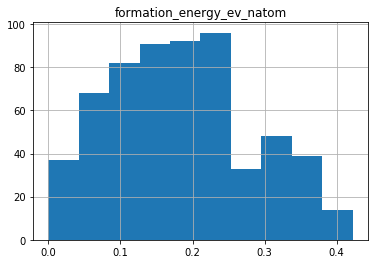

In [79]:
sub[["formation_energy_ev_natom"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f817d759f60>]], dtype=object)

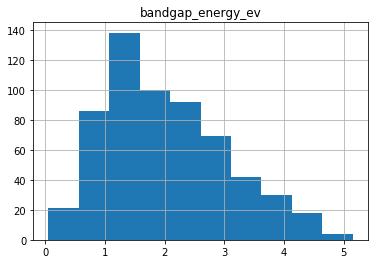

In [80]:
sub[["bandgap_energy_ev"]].hist()

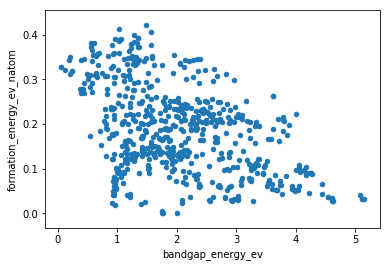

In [81]:
sub.plot.scatter(x='bandgap_energy_ev',y='formation_energy_ev_natom')

In [ ]:
sub.head(1)